# Mode-Turbulence Coupling: Numerical Analysis
# Plots for paper
## Ma = 0.2

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn import preprocessing
from scipy import integrate
import random
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import math
import scipy.interpolate as interpolate
from functools import reduce
import statistics

### Parameters

In [2]:
n_bins = 200
# n_samples is the number of eddy turnovers
n_samples = 25

# mach number Ma
Ma = 0.2

Tr = 2*np.pi / Ma

axis_font = {'size':'25'}
title_font = {'size':'30'}

### Functions

In [3]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(Tr, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()

# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html
#deltaT is the length of each eddy turnover
def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(Tr, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's
def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    time=Tturb
    time.pop(-1)
    return Tturb, time

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funF1(meanF1, stdF1, Tr):

    y1=0
    F1=[]
    prob=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF1**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F1.append(meant-stdevt+2*stdevt*R)
        y1=F1[i]
    return F1

def funF2(meanF2, stdF2, Tr):

    y1=0
    F2=[]

    for i in range(len(t)):
        arr=[]
        time=t[i]
        stdevt=((1-math.exp(-2*time/Tr))*stdF2**2)**(1/2)
        meant=math.exp(-time/Tr)*y1
        R=random.uniform(0,1)
        F2.append(meant-stdevt+2*stdevt*R)
        y1=F2[i]
    return F2

# set G1 = 0
def funG1(F1):
    G1=[]
    for i in range(len(F1)):
        G1.append(0)
    return G1



def funAmp(dAdT, AT):

    #A is the amplitude
    A=[]
    #t is time
    t=[]
    #derivA is the derivative of A with respect to time
    derivA=[]
    f1=[]
    g1=[]
    f2=[]
    
    #F2=constant=c
    #1+G1=constant=b
    #F1=constant=a
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        q=1/2*(4*b-a**2)**(1/2)
        
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C0prime=math.exp(-a*Tturb[i]/2)*C0
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        C1prime=math.exp(-a*(Tturb[i])/2)*C1
        
                
        #Ttemp is an array containing the times between each eddy turnover 
        #(which starts at 0 and ends at deltaT)
        Ttemp=np.linspace(0, deltaT[i])
        
        #this for loop below loops through each eddy turnover:
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(Tturb[i]+j)
                f1.append(a)
                g1.append(b-1)
                f2.append(c)
                
                A.append(math.exp(-a*j/2)*(C0prime*math.sin(q*(Tturb[i]+j))+C1prime*math.cos(q*(Tturb[i]+j)))+c/b)
                derivA.append(math.exp(-a*j/2)*((C0prime*q-C1prime*a/2)*math.cos(q*(Tturb[i]+j))-(C0prime*a/2+C1prime*q)*math.sin(q*(Tturb[i]+j))))
                
        #resets the initial conditions for the next eddy turnovers to match the conditions at the end of the previous eddy turnover
        dAdT=derivA[-1]
        AT=A[-1]
            
    
    return A, t, f1, g1, f2

In [4]:
# Average value of Amplitude
def FunAsqr(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    return Asqr

# log(A)
def FunLog(A):
    logA = []
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

# 1/2*log(A^2)
# same as log(abs(A)) above
def FunHalfLogASqr(A):
    logAsqr = []
    for i in A:
        logAsqr.append(1/2*math.log10(i*i))
    return logAsqr

# Root mean square
def FunRMS(A):
    Asqr = []
    for i in A:
        Asqr.append(i**2)
    avg = np.sum(Asqr) / len(Asqr)
    RMS = avg**(1/2)
    return RMS
    

In [5]:
def Funplots(t, A, f1, f2):

    plt.figure(figsize=(40,10))
    plt.plot(t, A, 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.show()

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F1', **axis_font)
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F2', **axis_font)
    plt.show()

### Parameters

In [6]:
# variables for generating F1
meanF1 = 0
stdF1 = Ma**3 / (2 * np.pi)

# variables for generating F2

stdF2 = Ma**2
meanF2 = 0

# initial conditions A(0)=1/2*stdF2, dA/dT(0)=0
dAdT = 0
AT = 1/2*stdF2

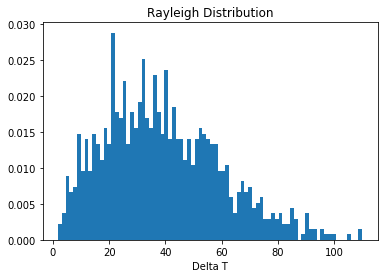

In [7]:
rayleighdistribution()

deltaT = fundeltaT(n_bins, n_samples)

Tturb, time = funTturb()

t = funt()

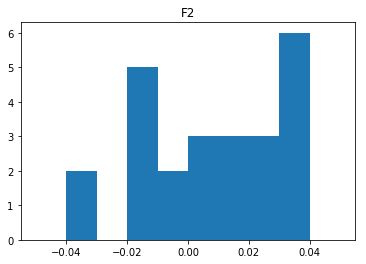

<F2^2>^(1/2) =  0.023701426342438964
Average Value of F2  0.006632306395650854
Maximum Value of F2  0.03890354369304999
Minimum Value of F2  -0.03422554815991114


In [8]:
F2 = funF2(meanF2, stdF2, Tr)
plt.hist(F2, 10, range=(-stdF2-.01, stdF2+.01))
plt.title("F2")
plt.show()

F2sqr=[]
for i in range(len(F2)-1):
    F2sqr.append(F2[i]**2)

rms=(sum(F2sqr) / len(F2sqr) )**(1/2)
print("<F2^2>^(1/2) = ", rms)
avgF2 = sum(F2) / len(F2)
print("Average Value of F2 ", avgF2)
print("Maximum Value of F2 ", max(F2))
print("Minimum Value of F2 ", min(F2))

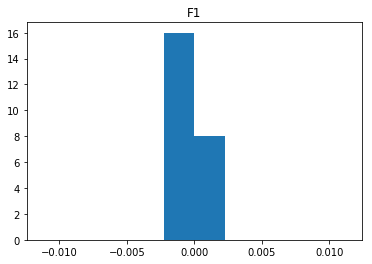

<F1^2>^(1/2) =  0.0007586619333602724
Average Value of F1  -0.0002586668002716894
Maximum Value of F2  0.0010168358883409895
Minimum Value of F1  -0.0016825071643589758


In [9]:
F1=funF1(meanF1, stdF1, Tr)
plt.hist(F1, 10, range=(-stdF1-.01, stdF1+.01))
plt.title("F1")
plt.show()

F1sqr=[]
for i in range(len(F1)-1):
    F1sqr.append(F1[i]**2)

rms=(sum(F1sqr) / len(F1sqr) )**(1/2)
print("<F1^2>^(1/2) = ", rms)

avgF1 = sum(F1) / len(F1)
print("Average Value of F1 ", avgF1)

print("Maximum Value of F2 ", max(F1))
    
print("Minimum Value of F1 ", min(F1))

In [10]:
G1 = funG1(F1)

##  Amplitude of mode, F1, F2, log(A) vs. Time

<Figure size 2880x720 with 0 Axes>

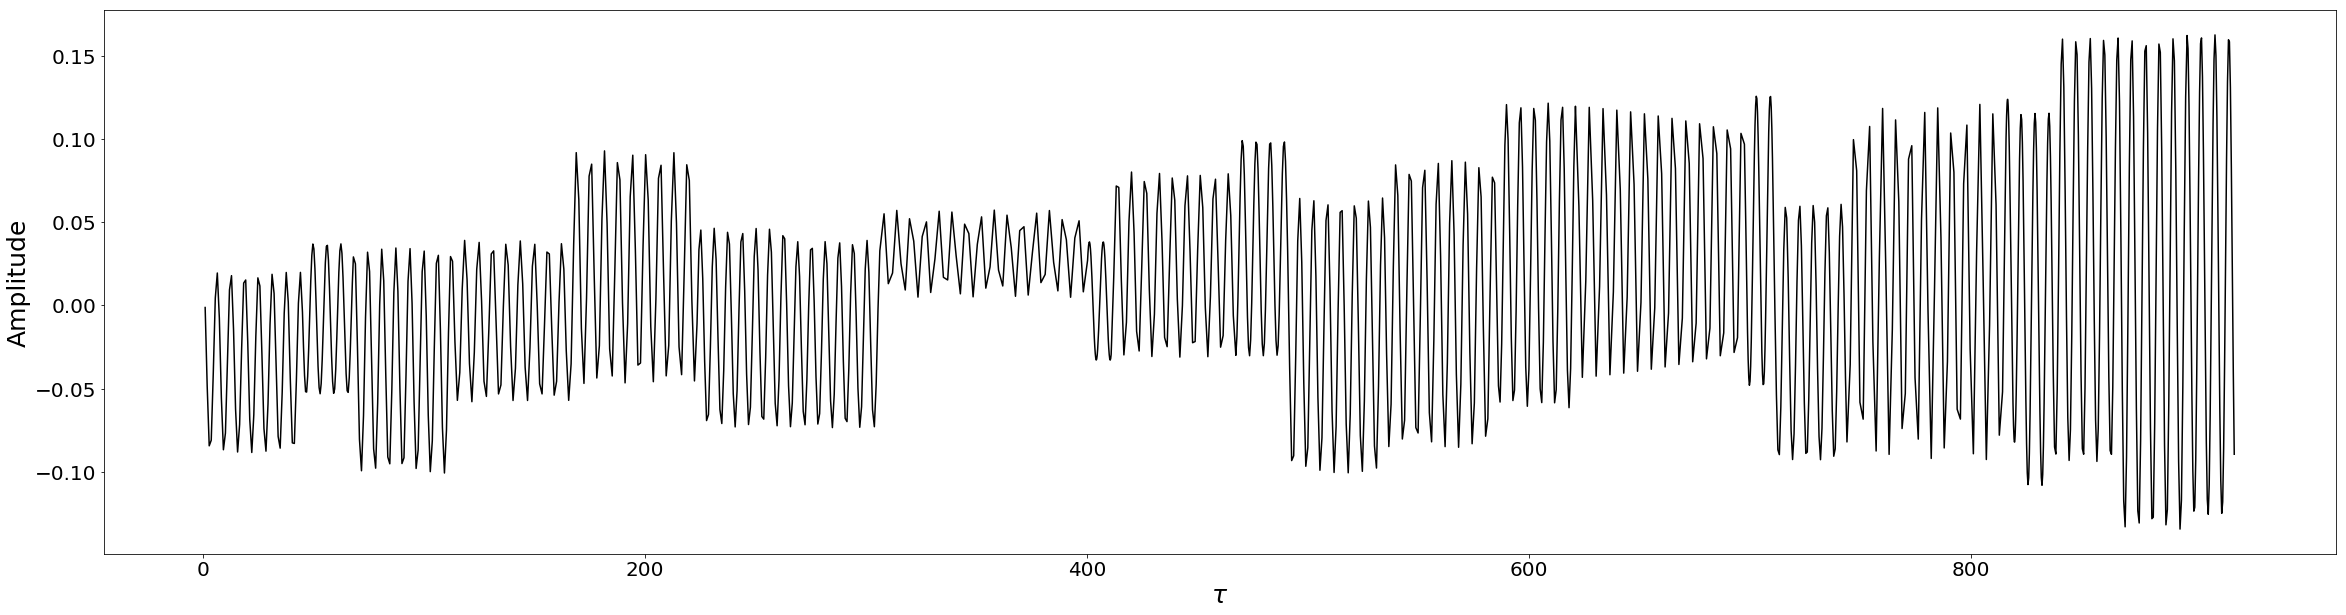

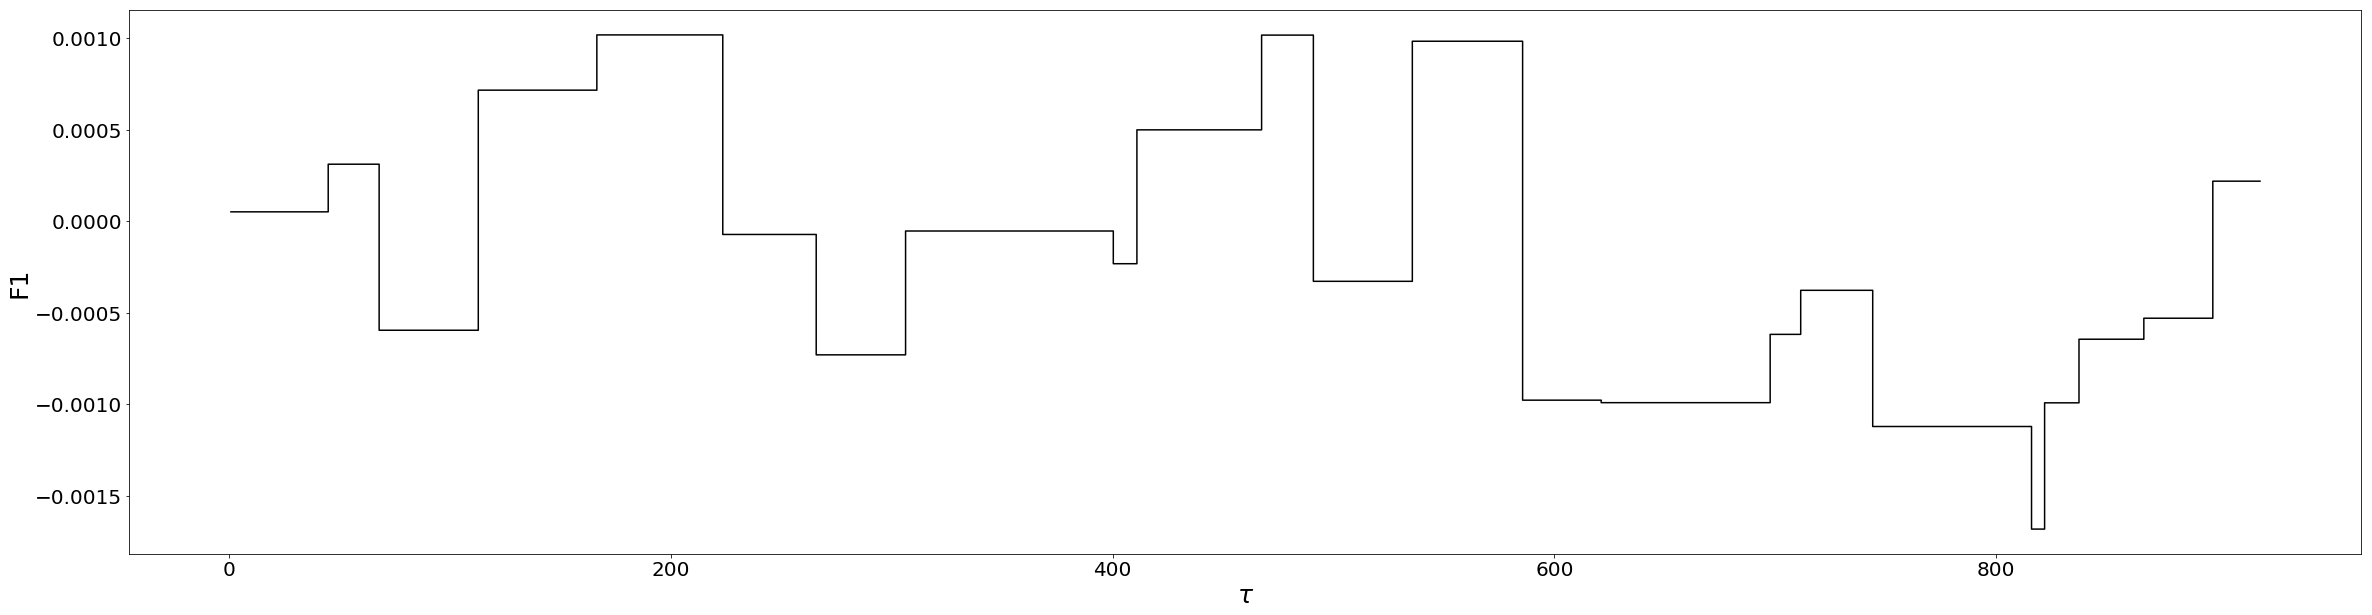

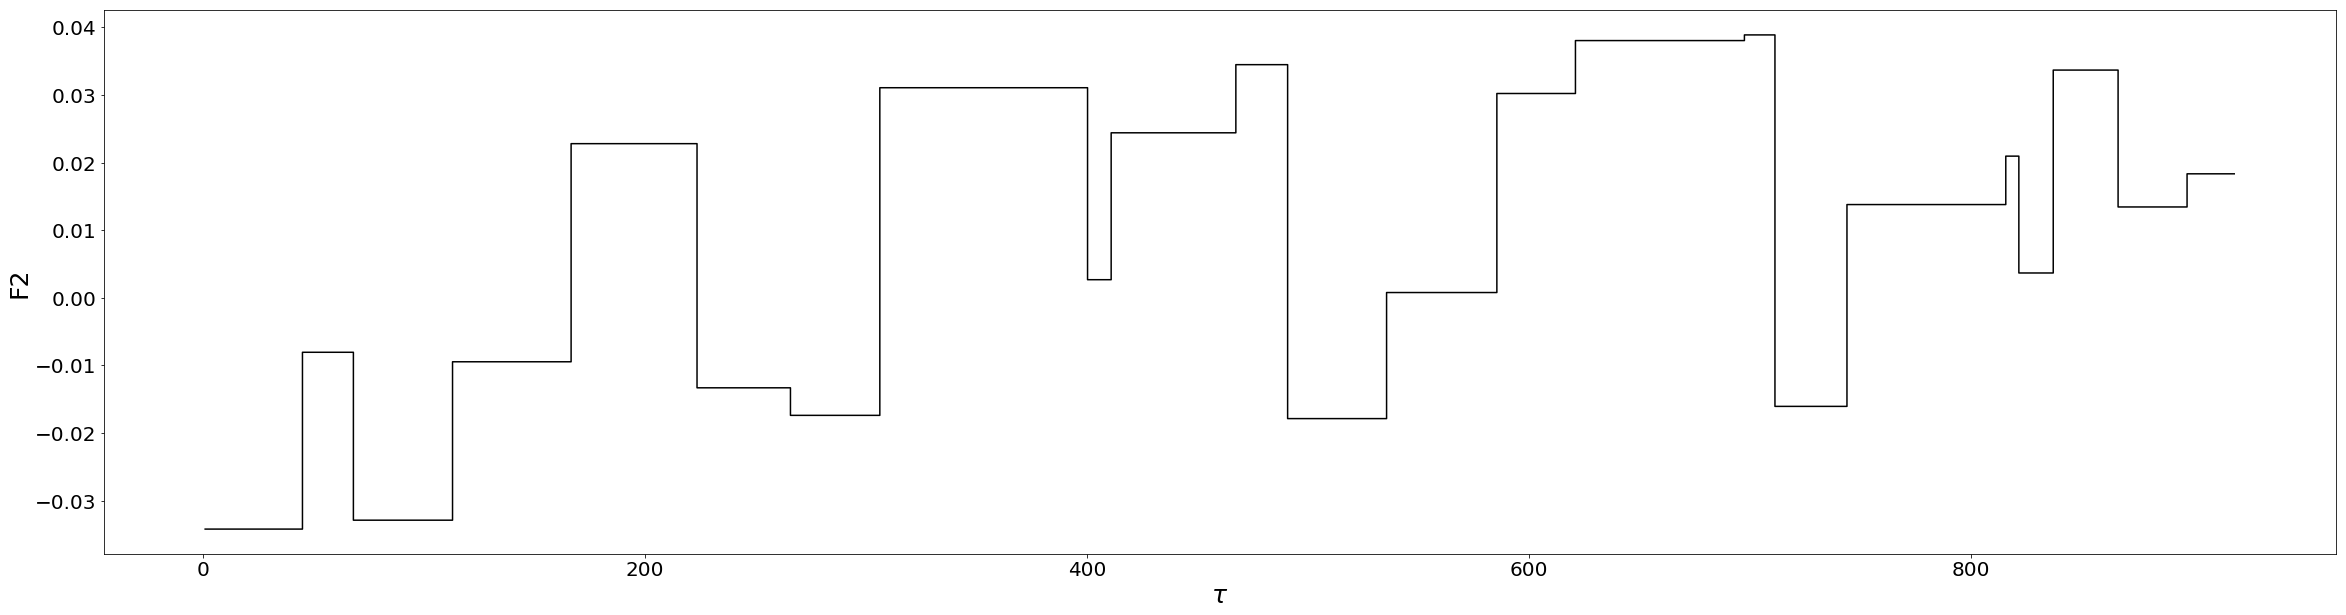

Amplitude of mode for 25 eddy turnovers
Average of A^2 = 0.0042551205993299375
median of A^2 = 0.002084283109919079
T(max) = 919.3546464012209


In [11]:
plt.figure(figsize=(40,10))
A, t, f1, g1, f2 =funAmp(dAdT, AT)
Funplots(t, A, f1, f2)

Asqr = FunAsqr(A)
avg = sum(Asqr) / len(Asqr)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("Average of A^2 =", avg)
print("median of A^2 =", statistics.median(Asqr))

# T(max) is the duration of each evolution
Tmax = t[-1]
# want T(max) ~ 2*pi*10^2
# T(max) = 2*pi*M
print("T(max) =", Tmax)

## Amplification Distribution Function

### Parameters

In [12]:
#compute L evolutions with different values of F1, F2, and DeltaT
L = 10

# set M ~ 10^4
M = 10**2

delA = 0.005
# n(max) ~ 1/delA, if Amax ~ 1

# divide T(max), the total duration, into equal segments delt = 2*pi*N

N = 4
delt = N * deltaT

### Function

In [13]:
def funGamma(A, t, gamma):

    # root mean square of amplitude for T(max)
    Abar_max = FunRMS(A)

    # the number of time segments is the total time (Tmax)/delT
    numsegments = int(Tmax/int(sum(delt)/len(delt)))+1

    # 2d array containing an array for amplitudes in each segments
    ampsegments = []

    # this loop divides the total duration T(max) into equal segments of delT
    # and adds corresponding amplitudes in each time segment to amsegments 
    i=0
    for count in range(0, numsegments):
        # amp segment contains the amplitudes in the specified time segment
        ampsegment = []
        # checks if that time is withint the correct time segment
        while i < len(t)-1:
            if (t[i] < (count+1)*2*np.pi):
                # adds the corresponding amplitude if the time is within specified time segment
                ampsegment.append(A[i])
                i+=1
            else:
                # breaks the while loop if the time is outside the time segment 
                # and moves to the next time segment
                break        
        ampsegments.append(ampsegment)


    # take Abar(T) = rms(A in delT)
    # Abar is the root mean square (RMS) of A in delT   
    Abar = []    
    for ampsegment in ampsegments:
        Abar.append(FunRMS(ampsegment))

    # in order to better exhibit the distribution of the full range of values of Abar, use instead
    # gamma = log(Abar) so -4 <= gamma <= 0
    tempgamma = FunLog(Abar)
    gamma.append(tempgamma)

    gamma_max = max(tempgamma)
    gamma_min = min(tempgamma)
    
    return gamma

def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

evolution 1 above
evolution  2


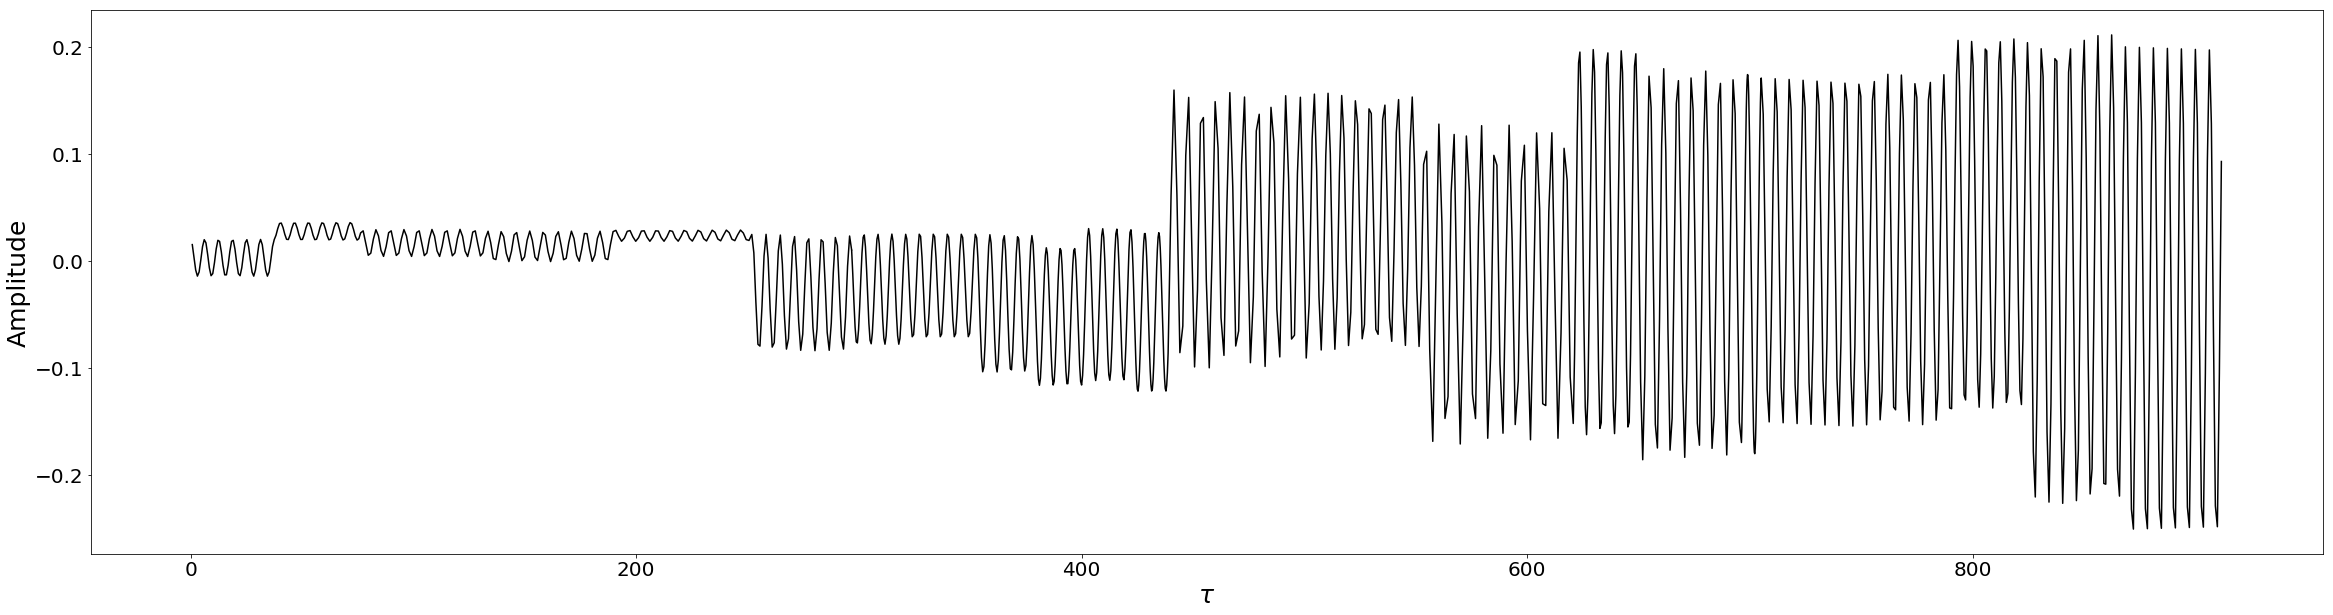

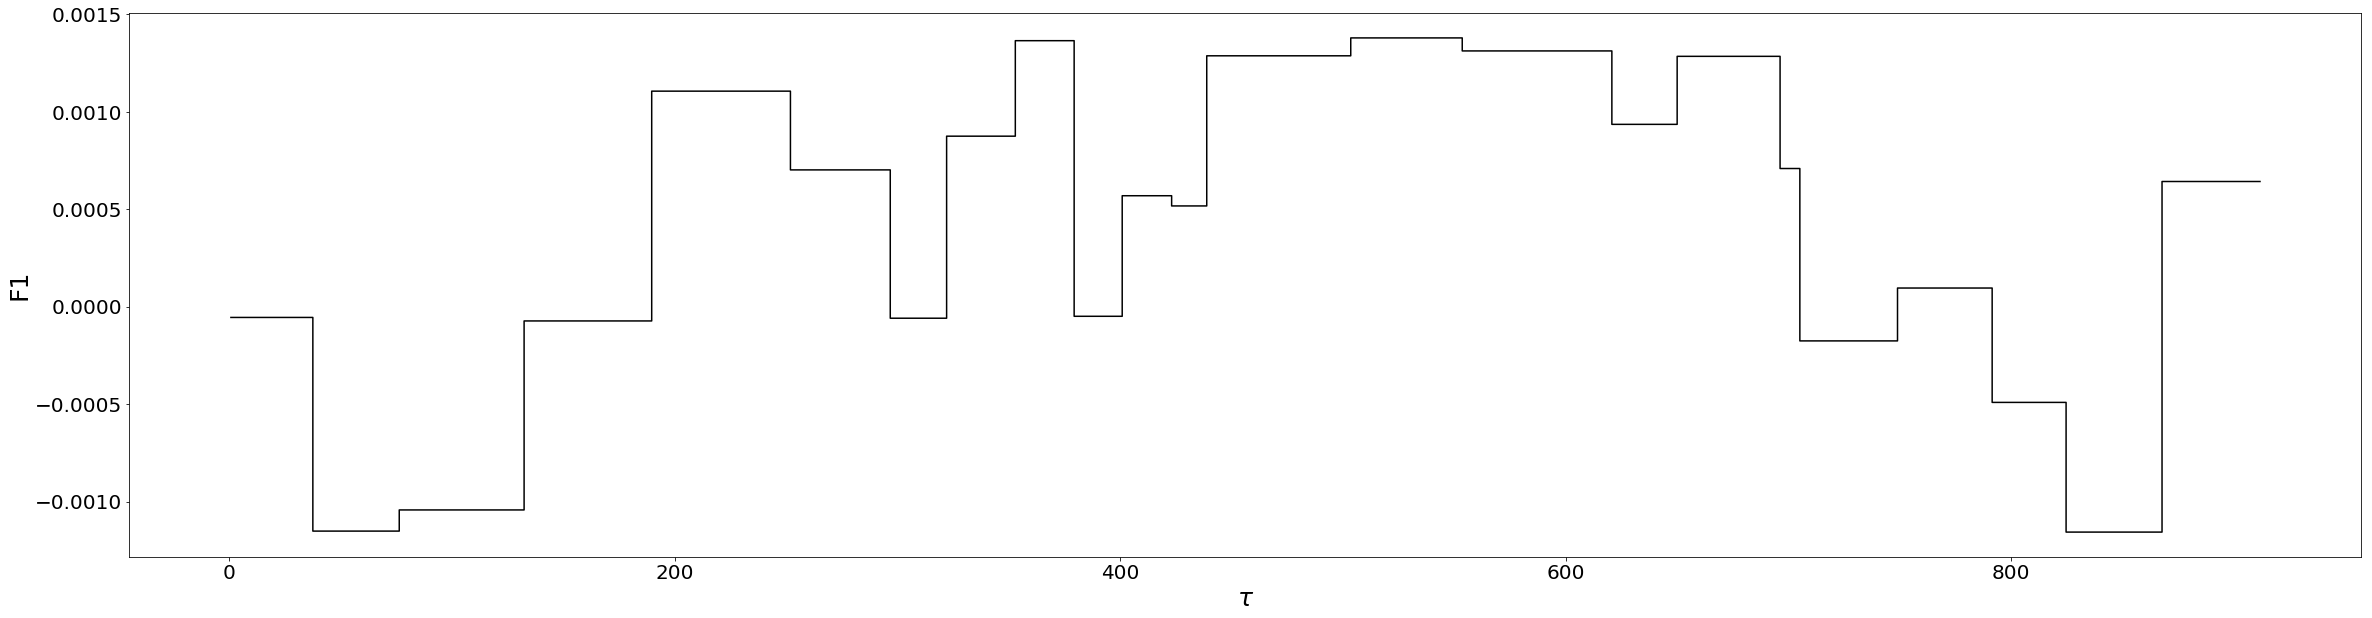

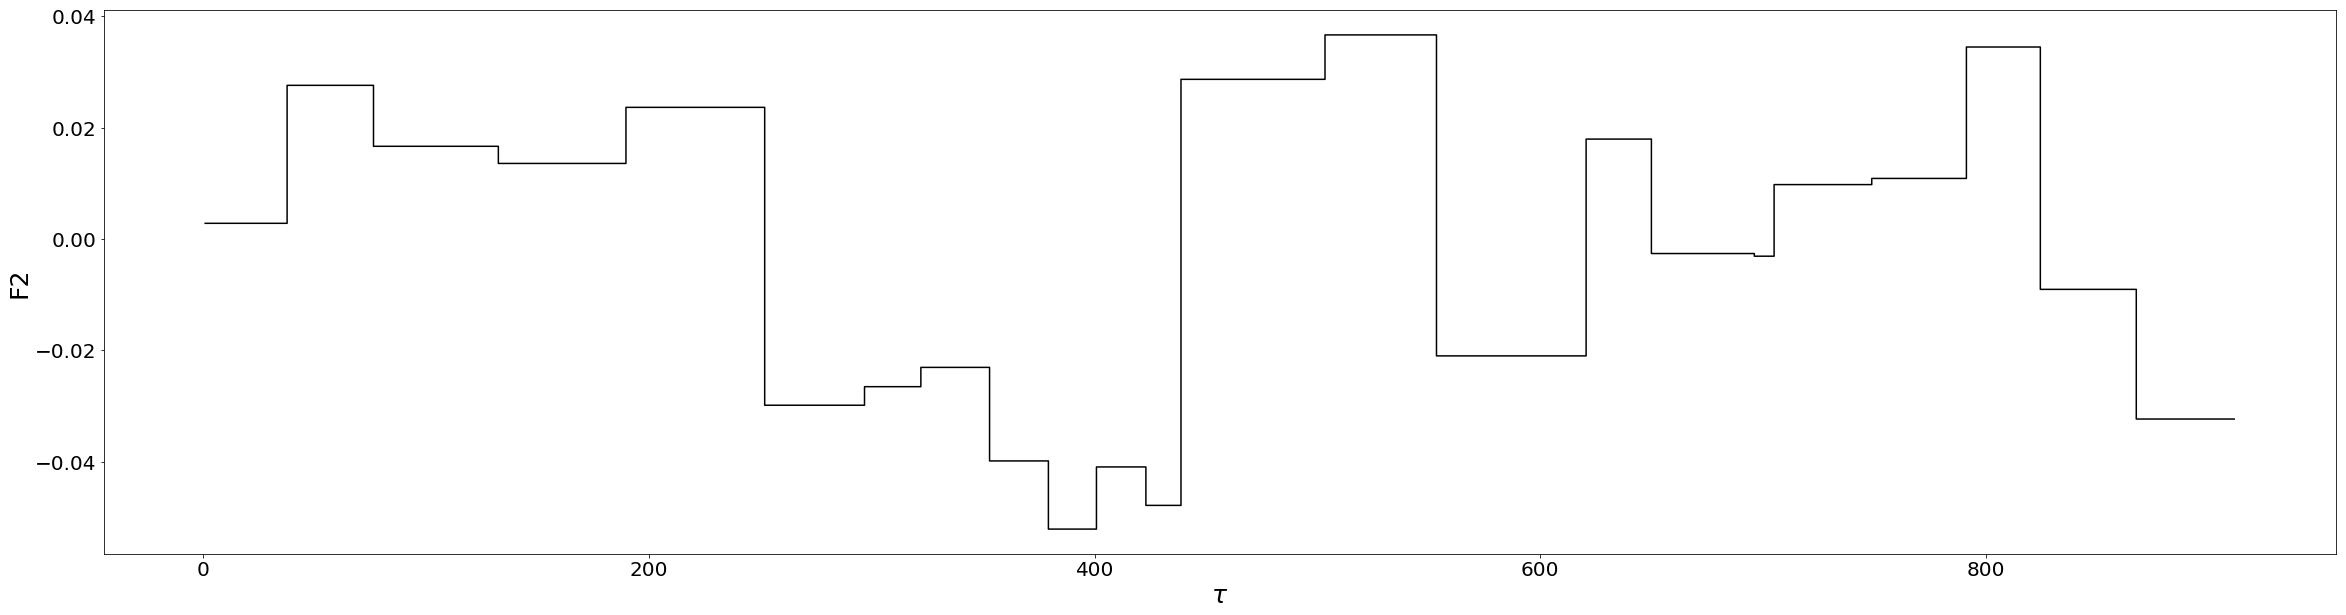



evolution  3


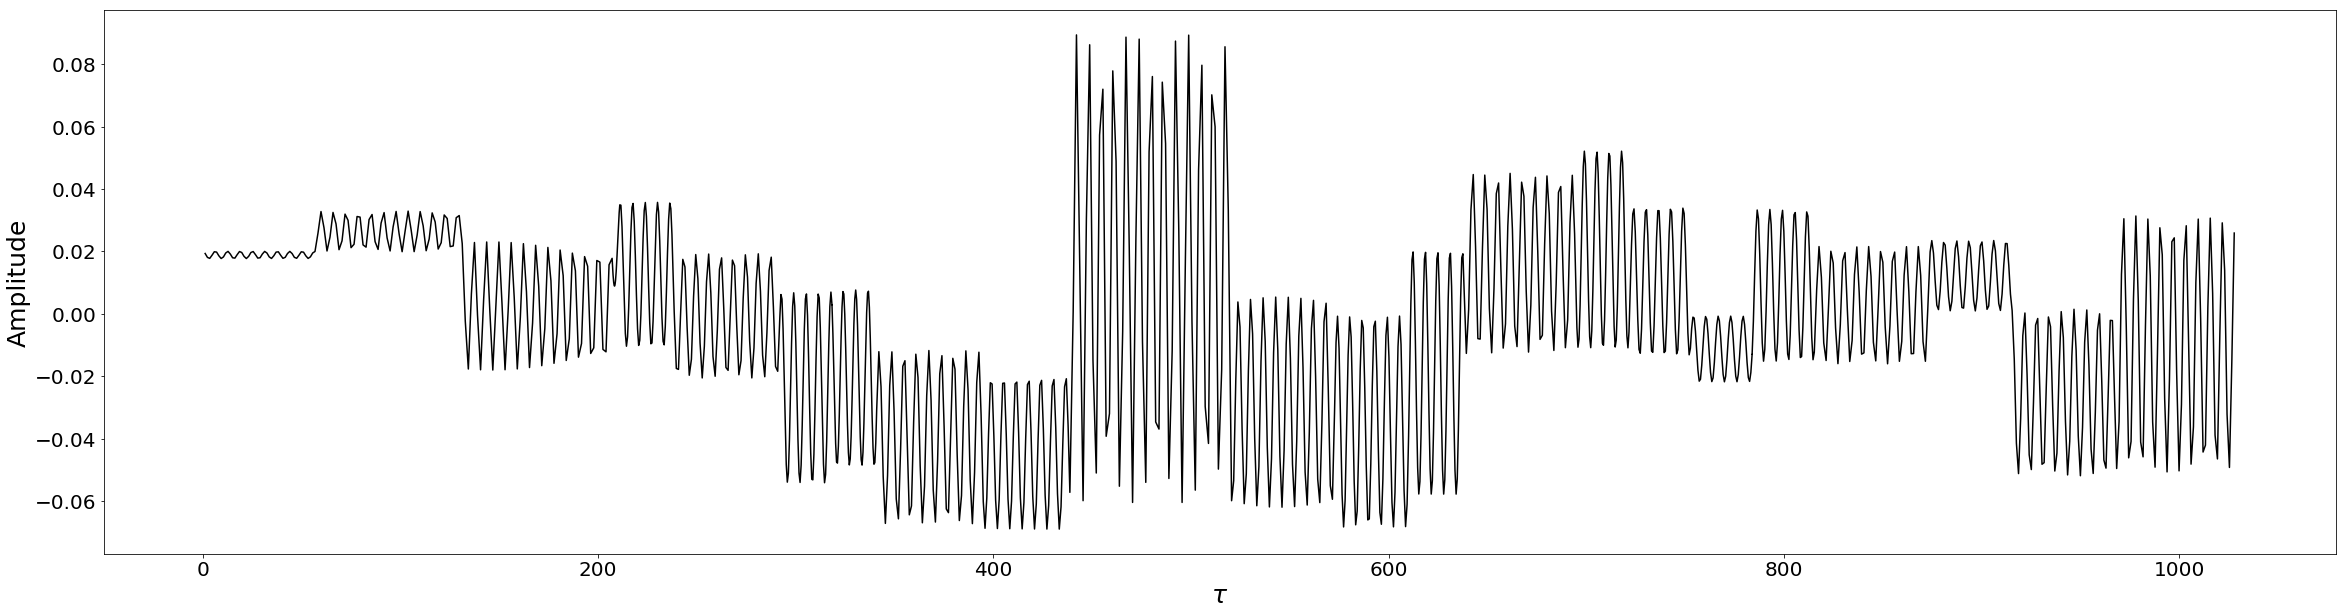

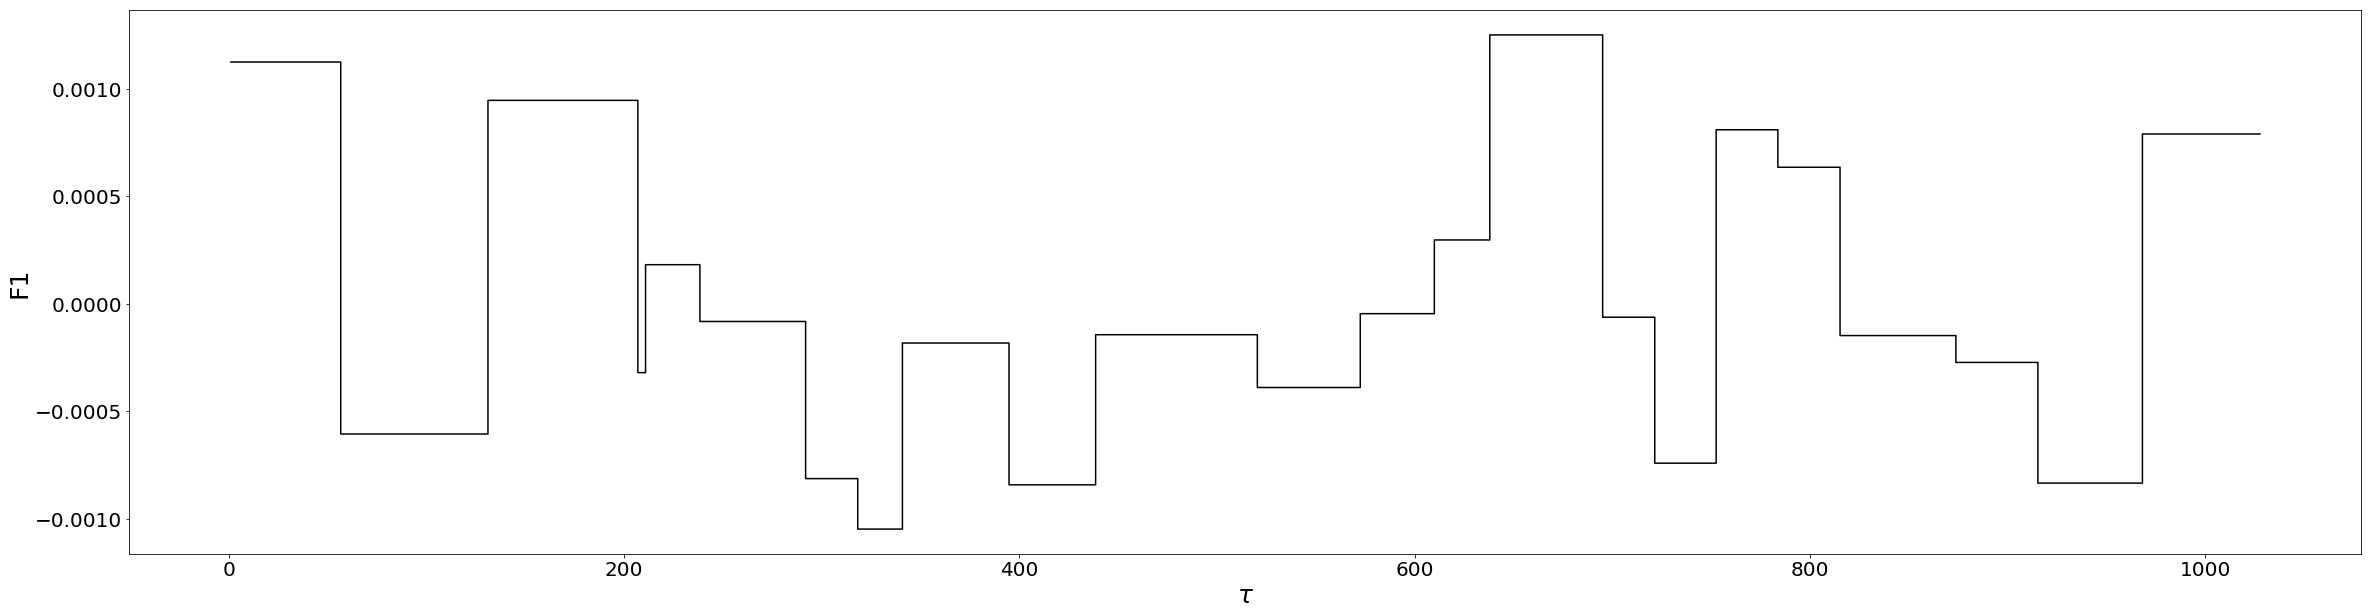

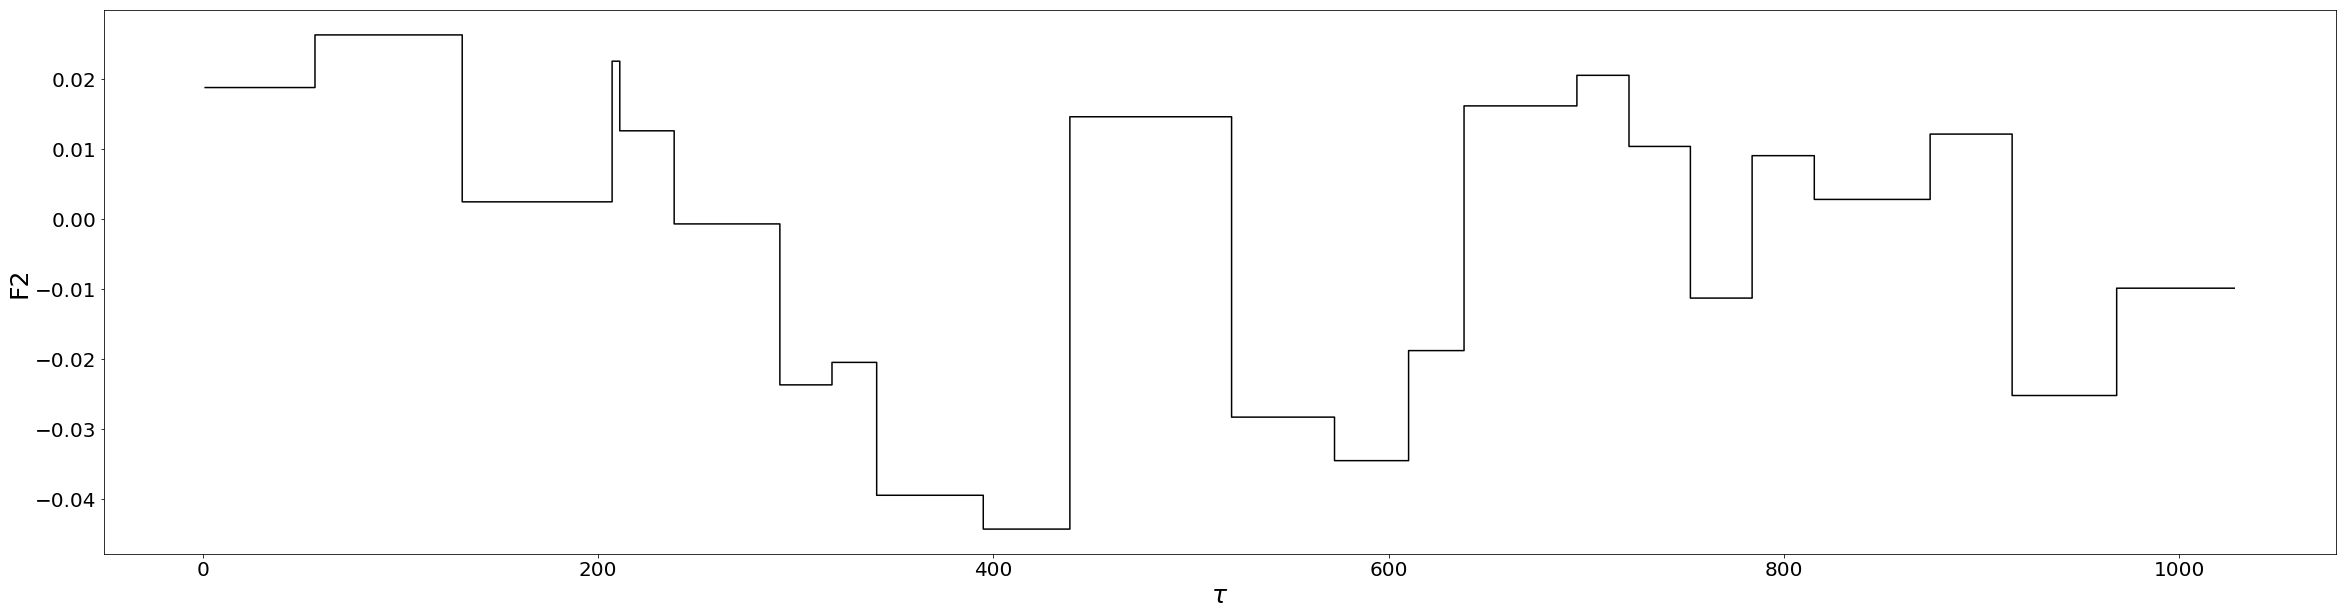



evolution  4


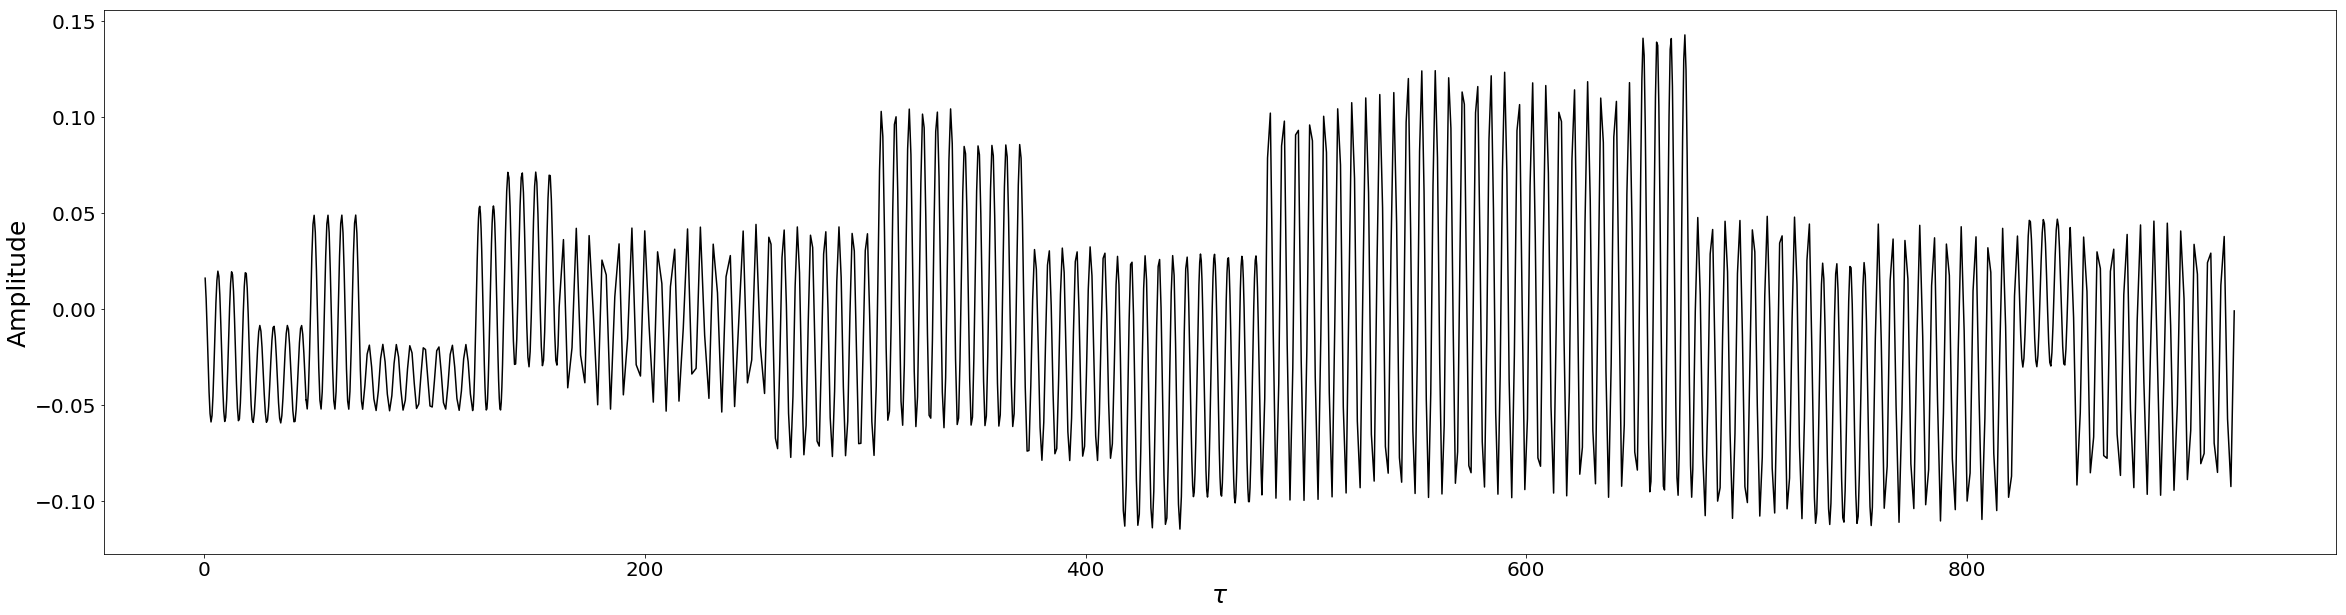

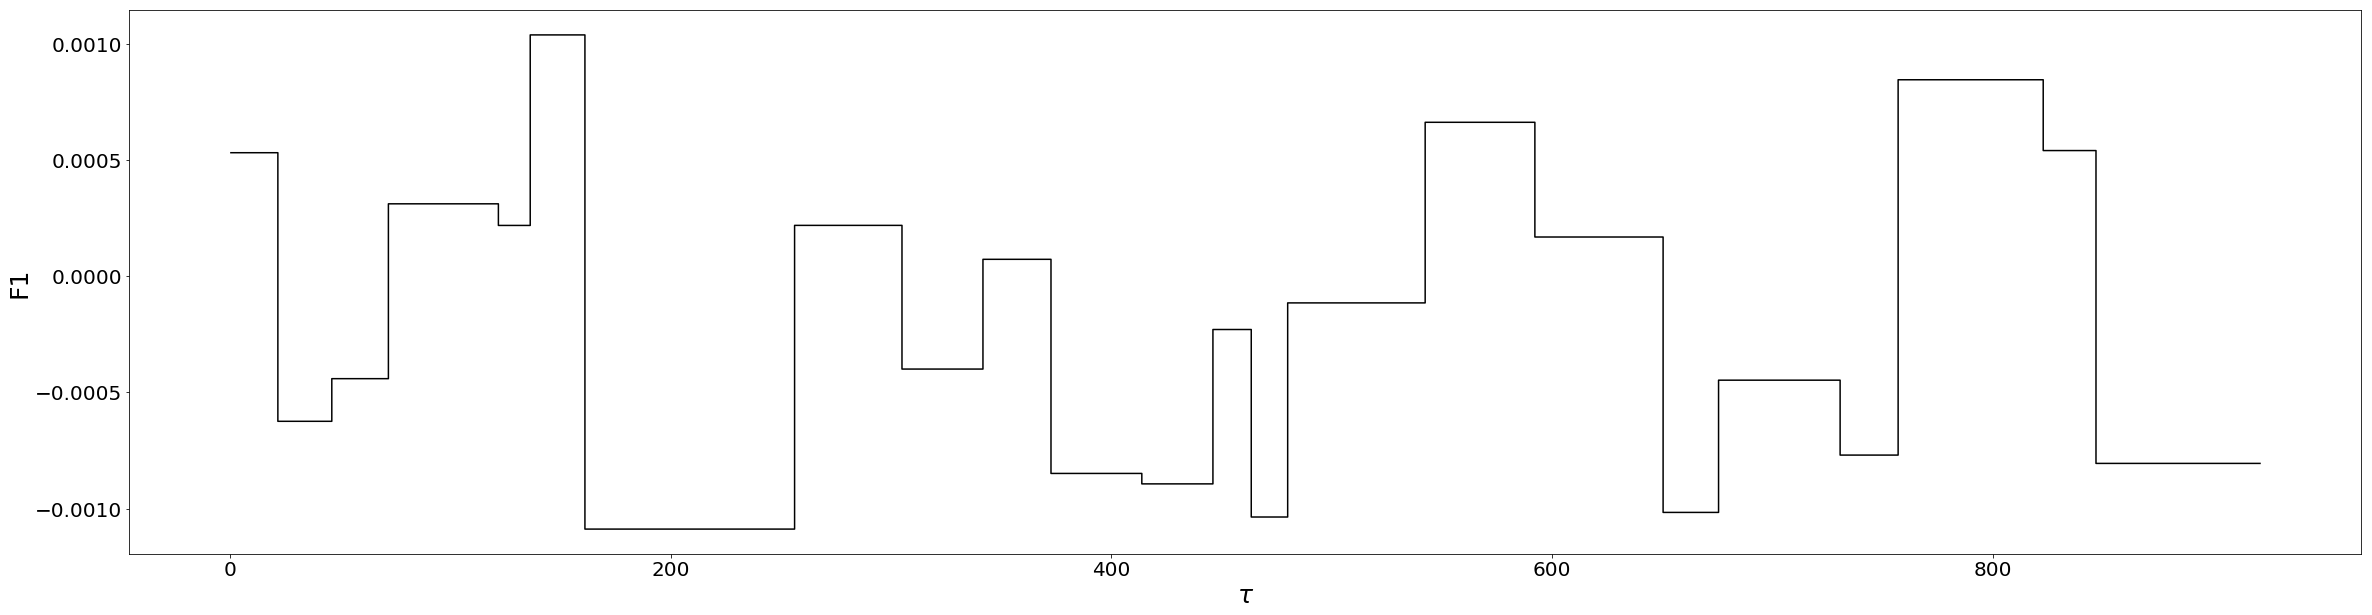

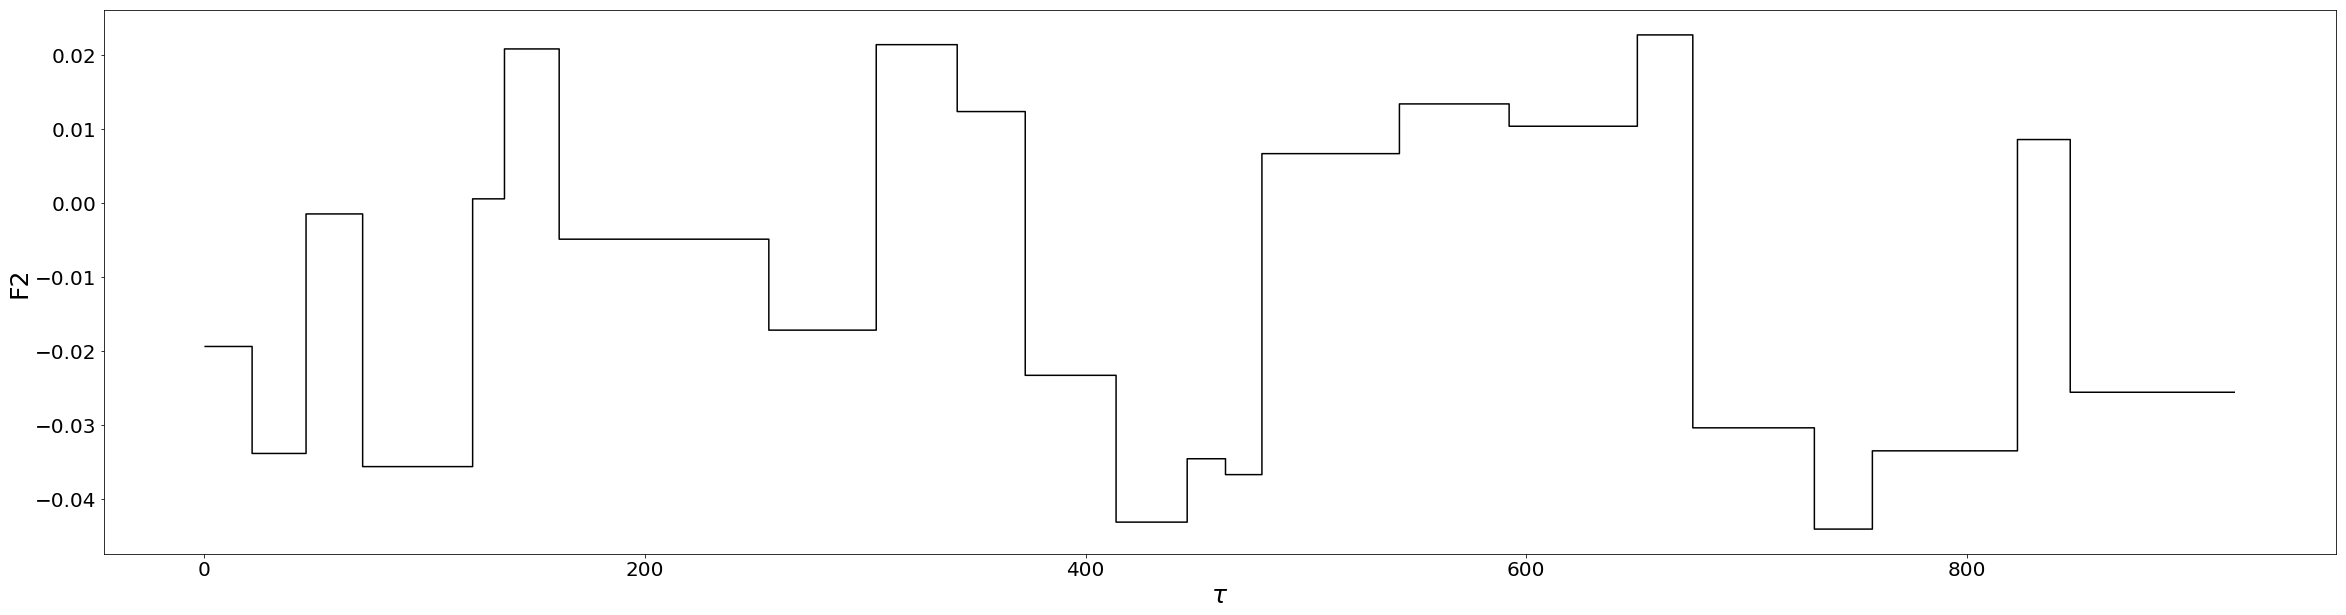



evolution  5


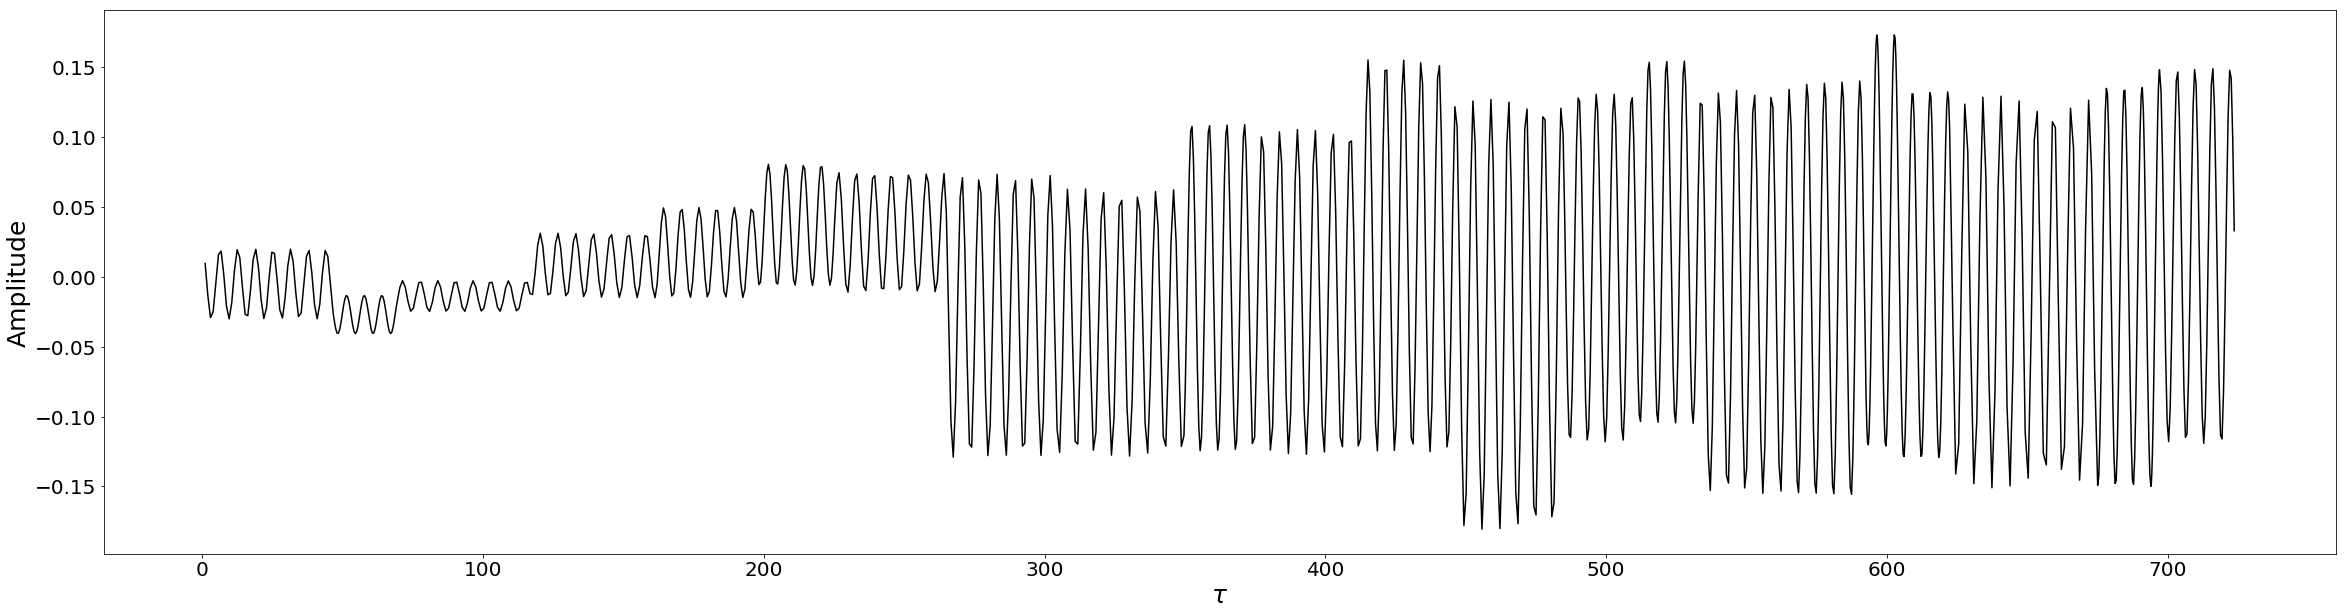

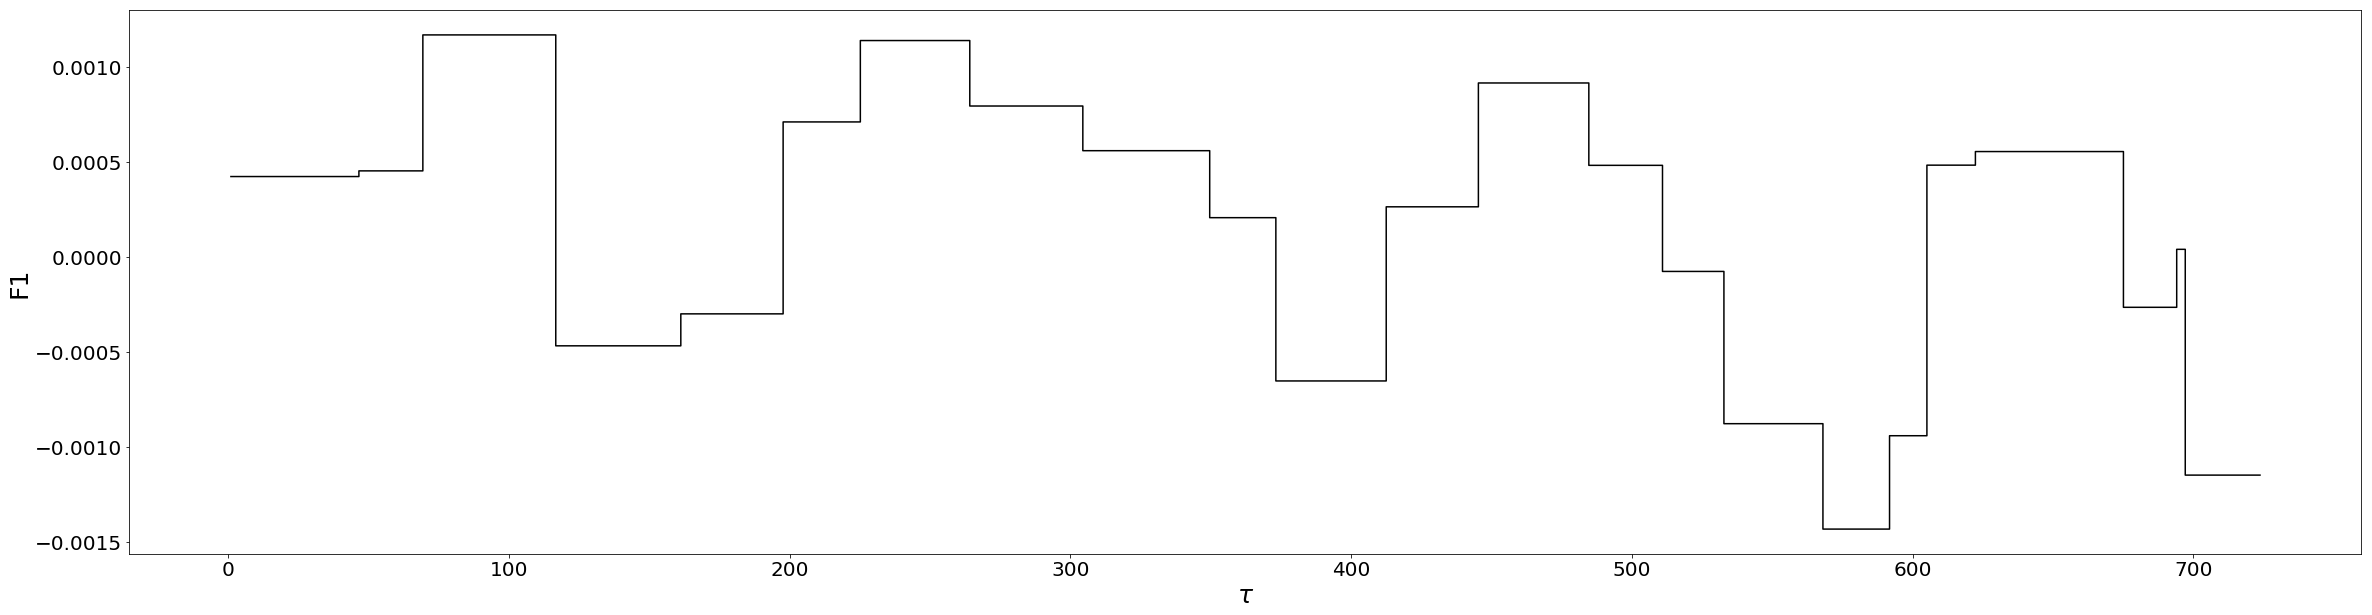

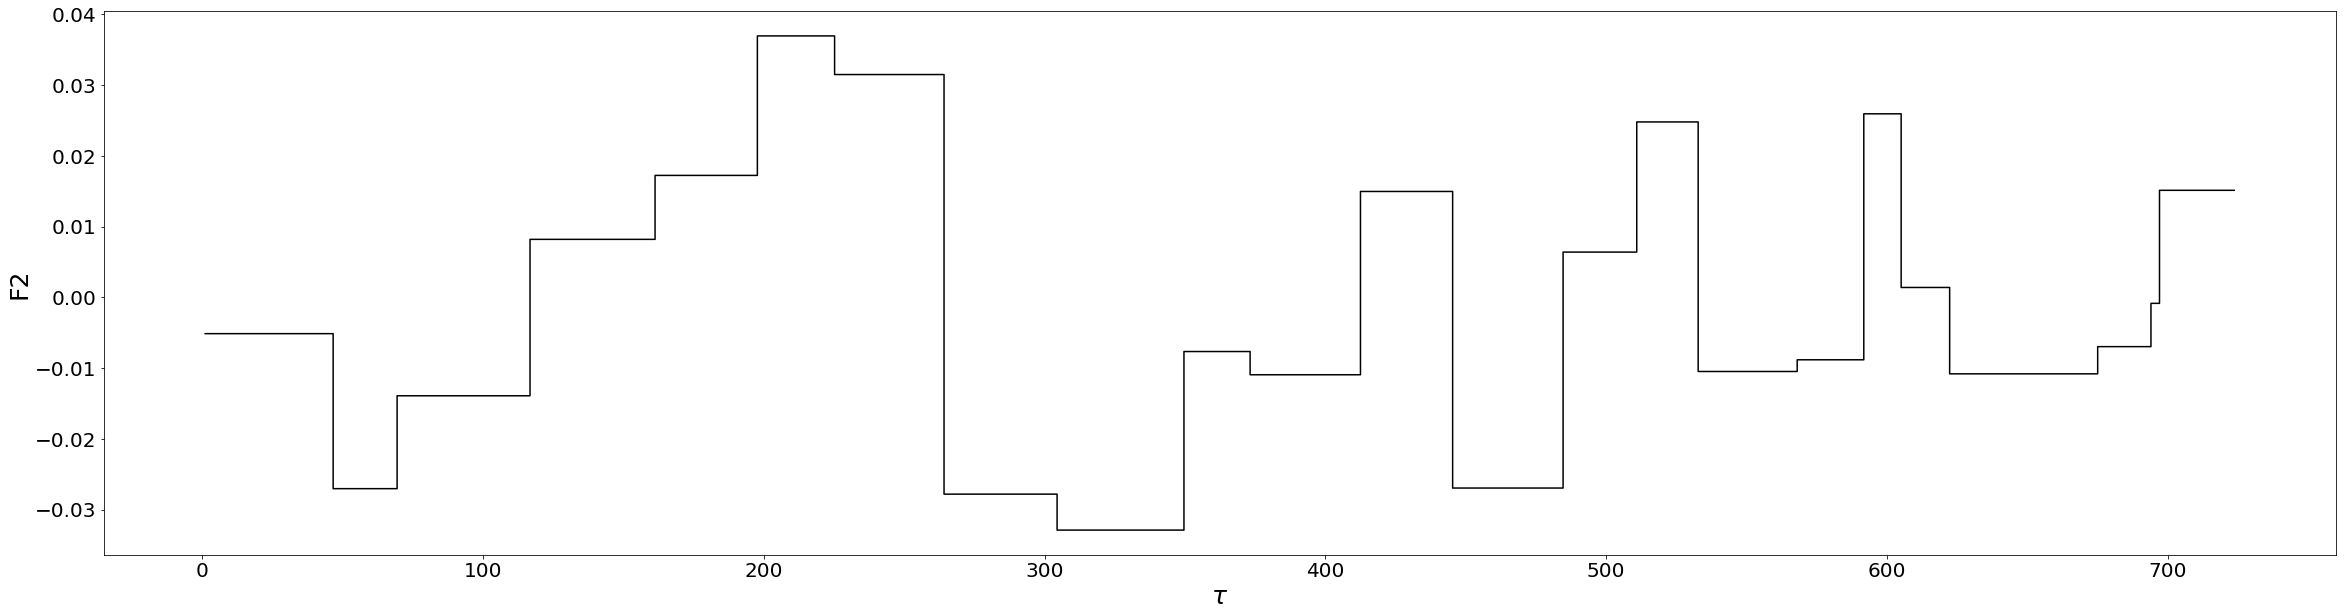



evolution  6


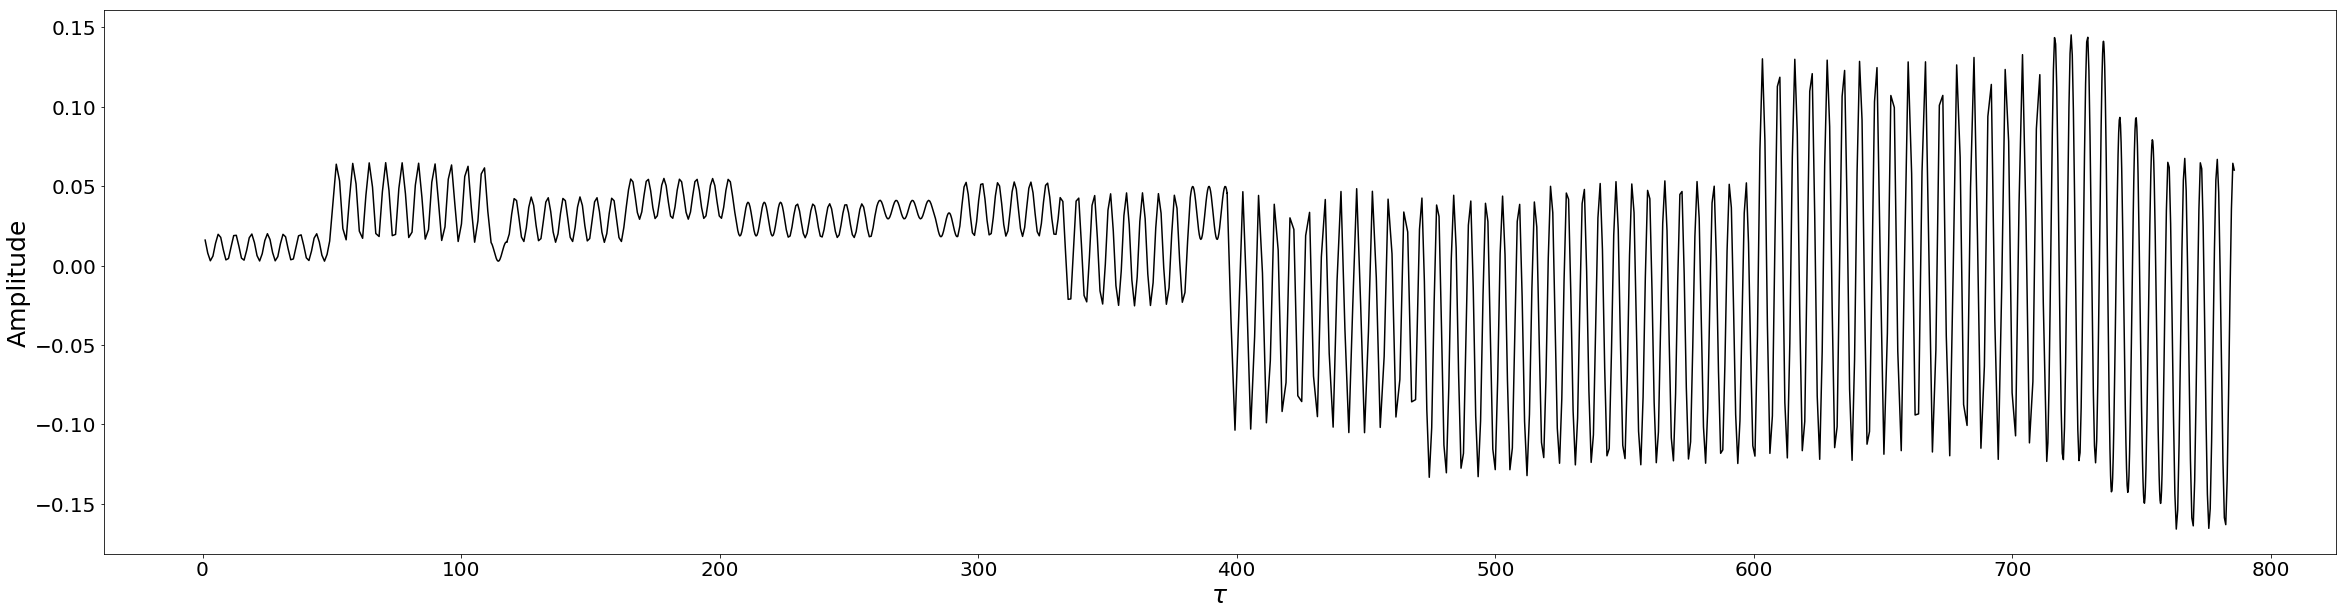

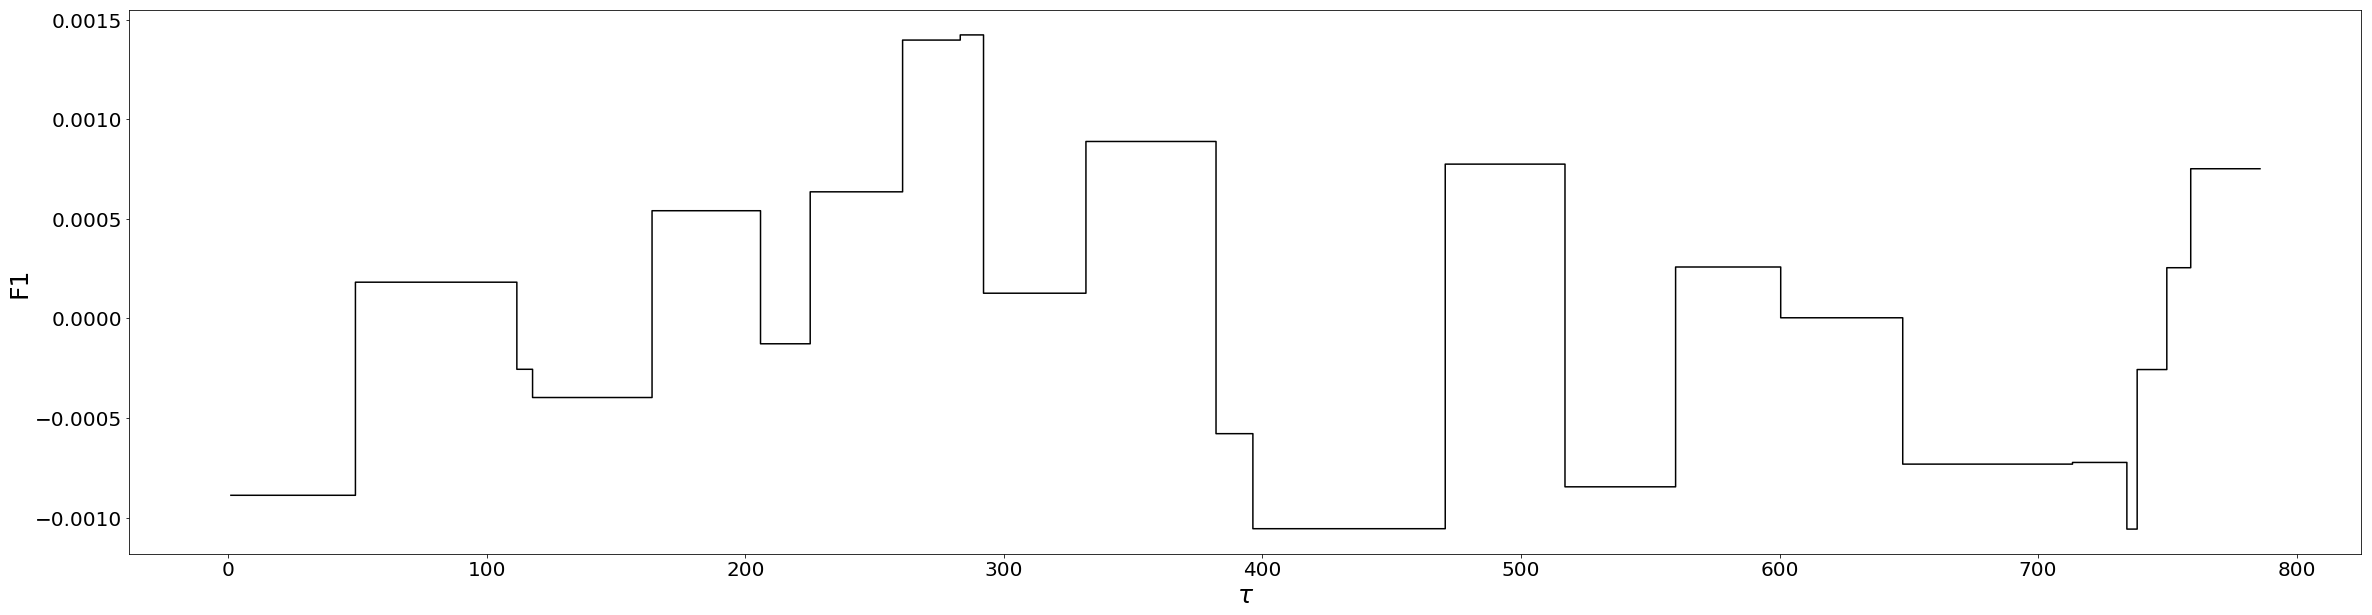

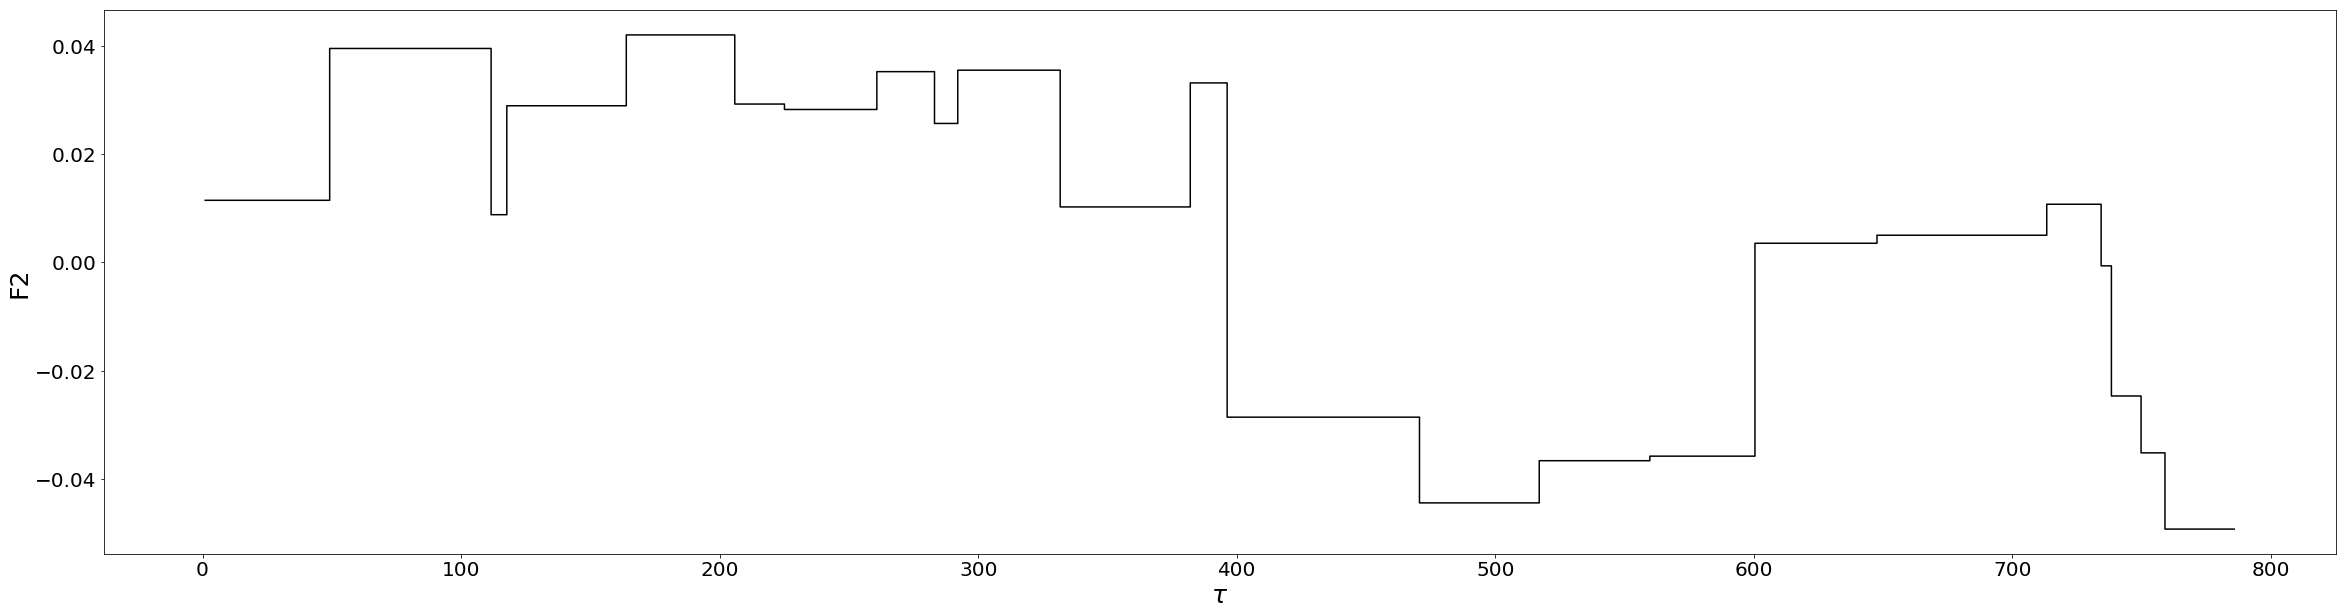



evolution  7


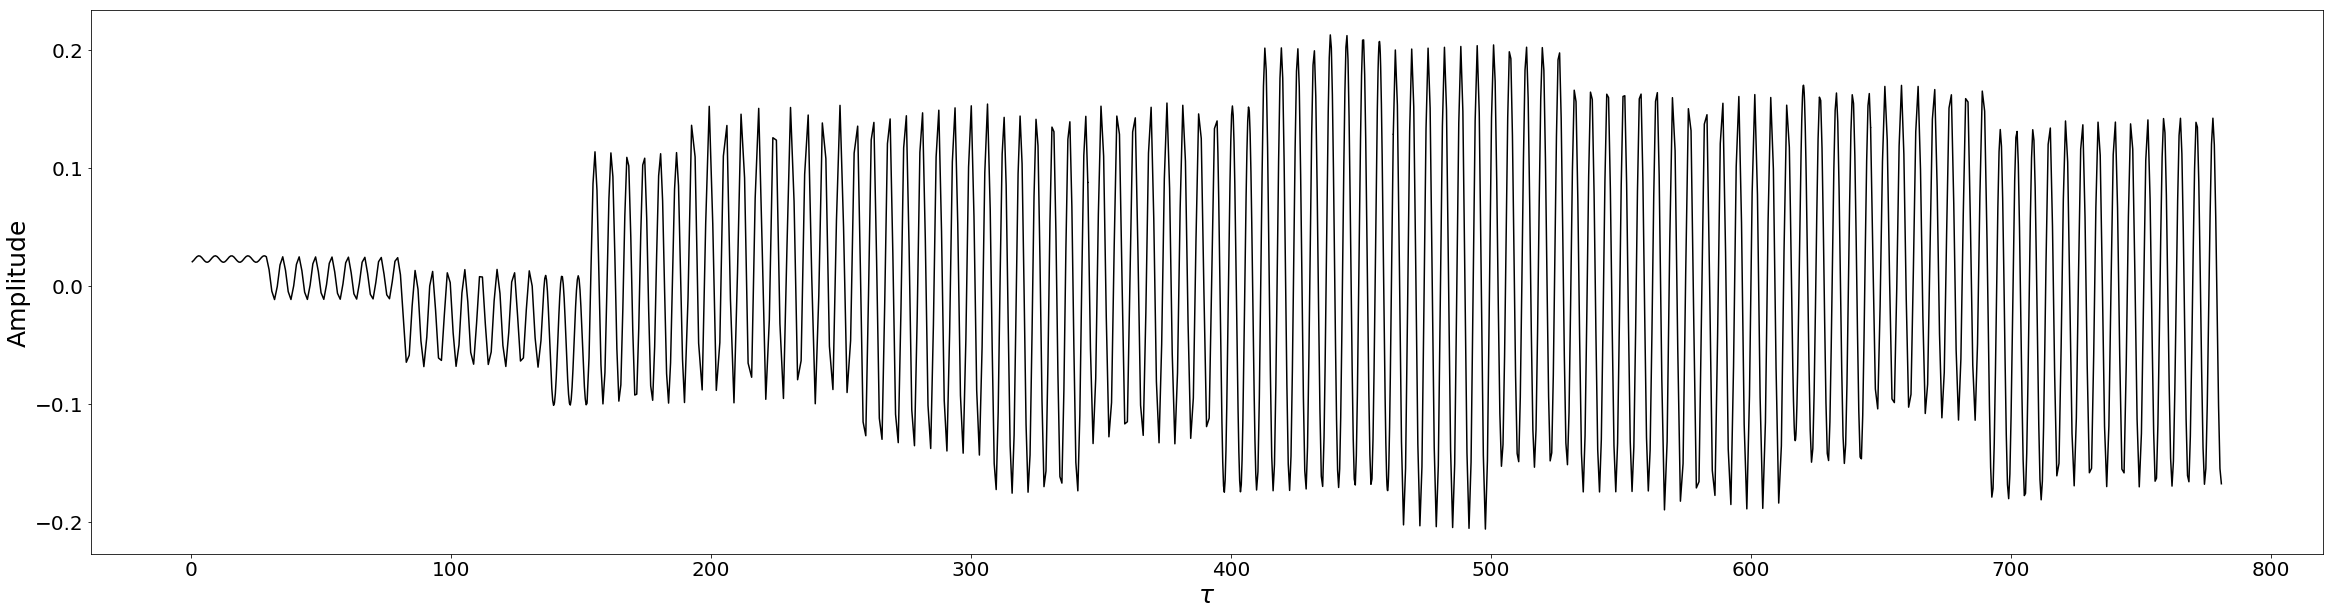

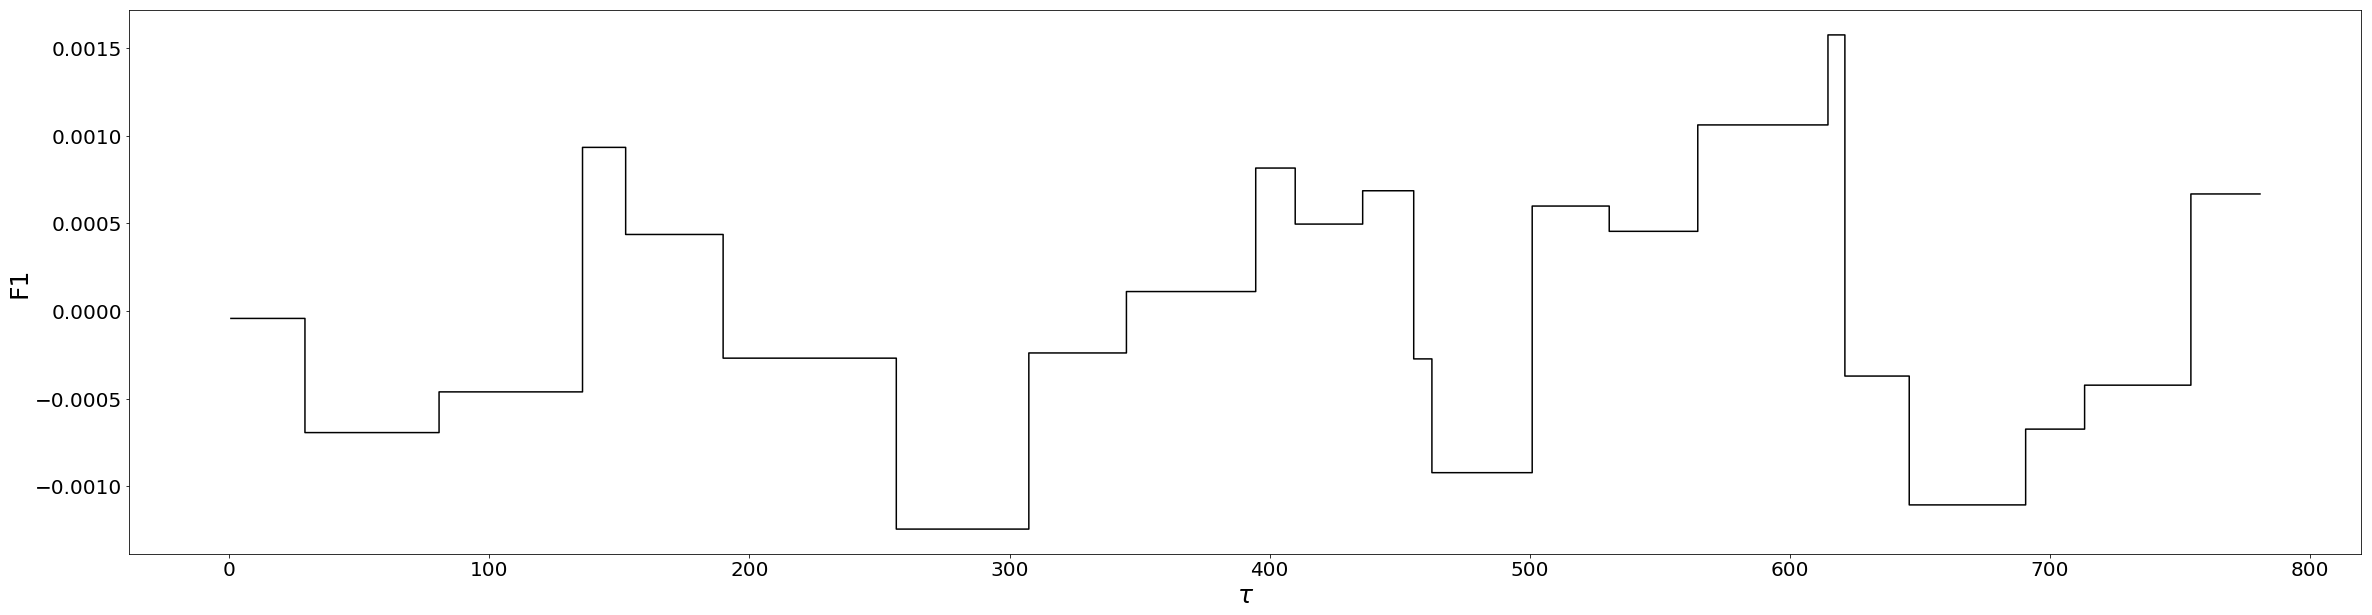

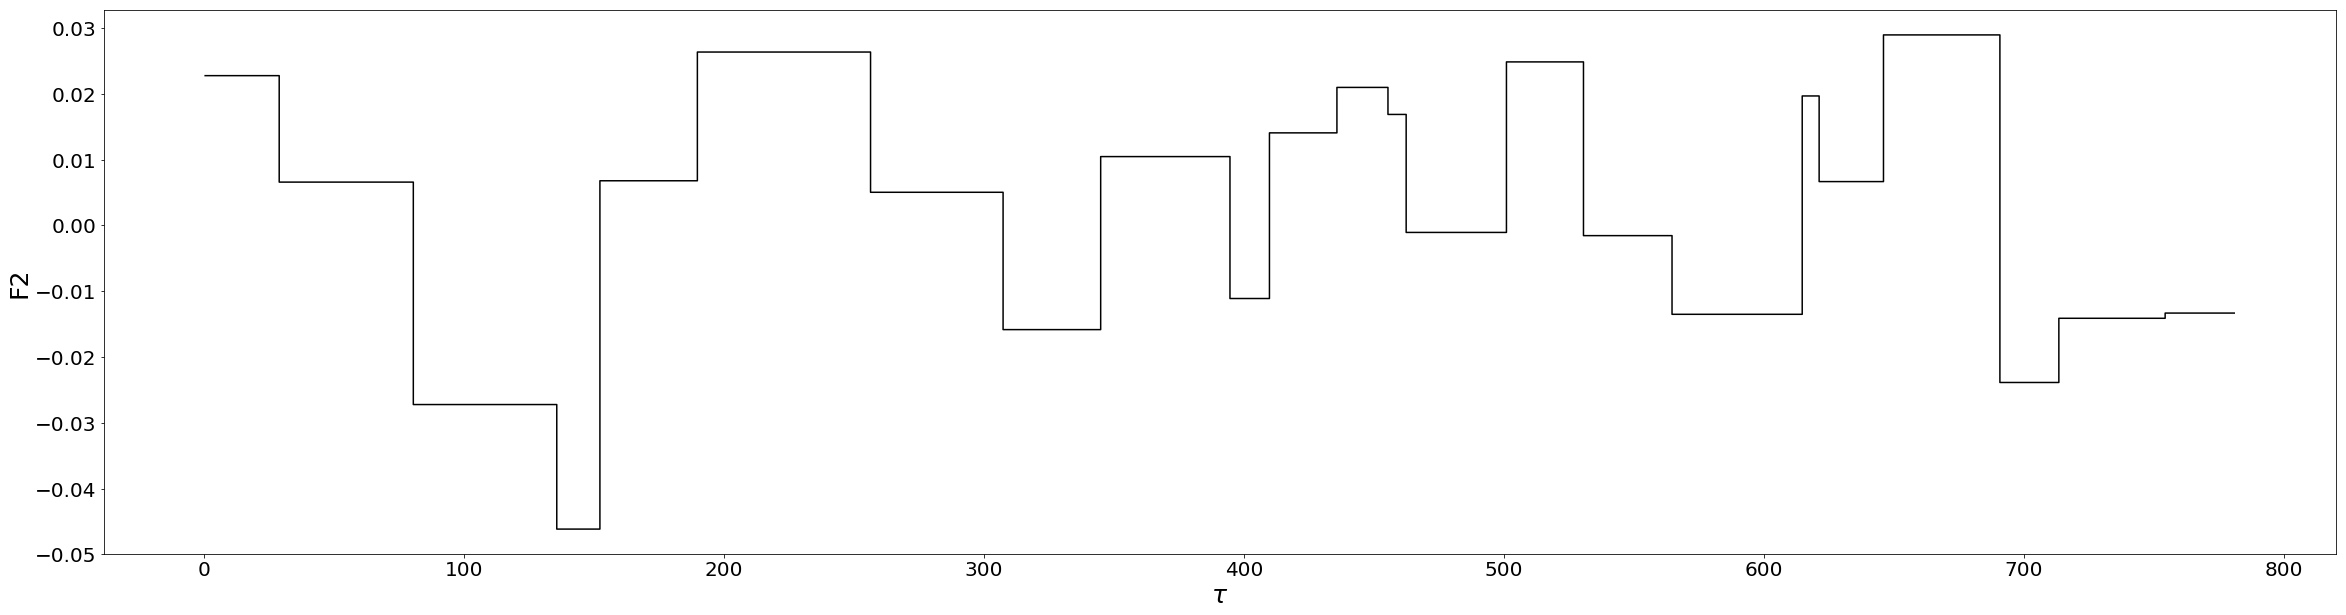



evolution  8


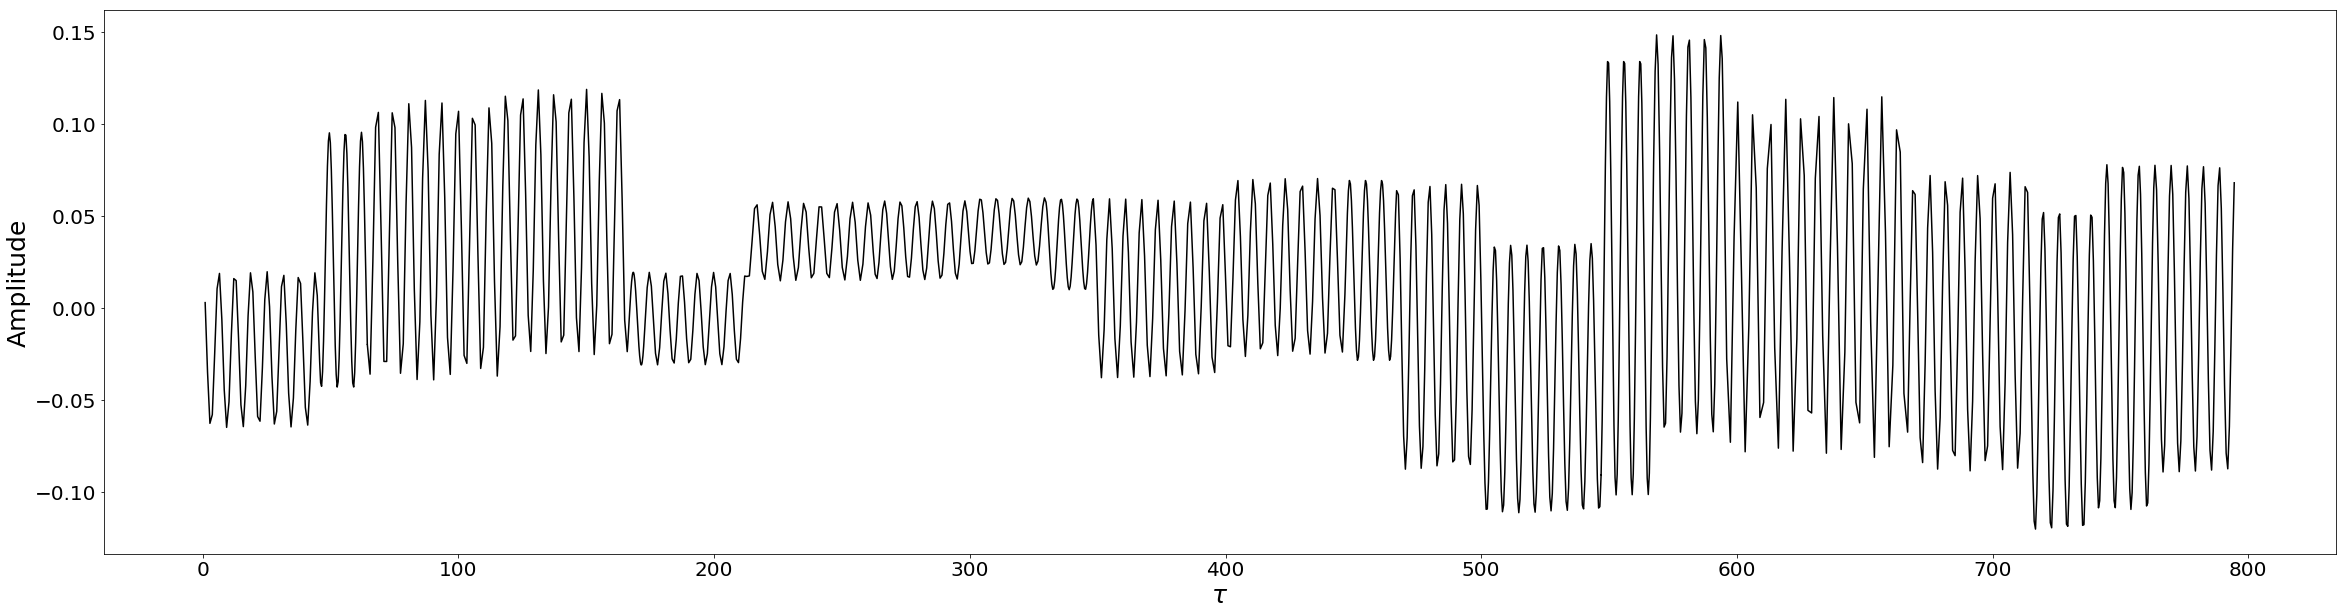

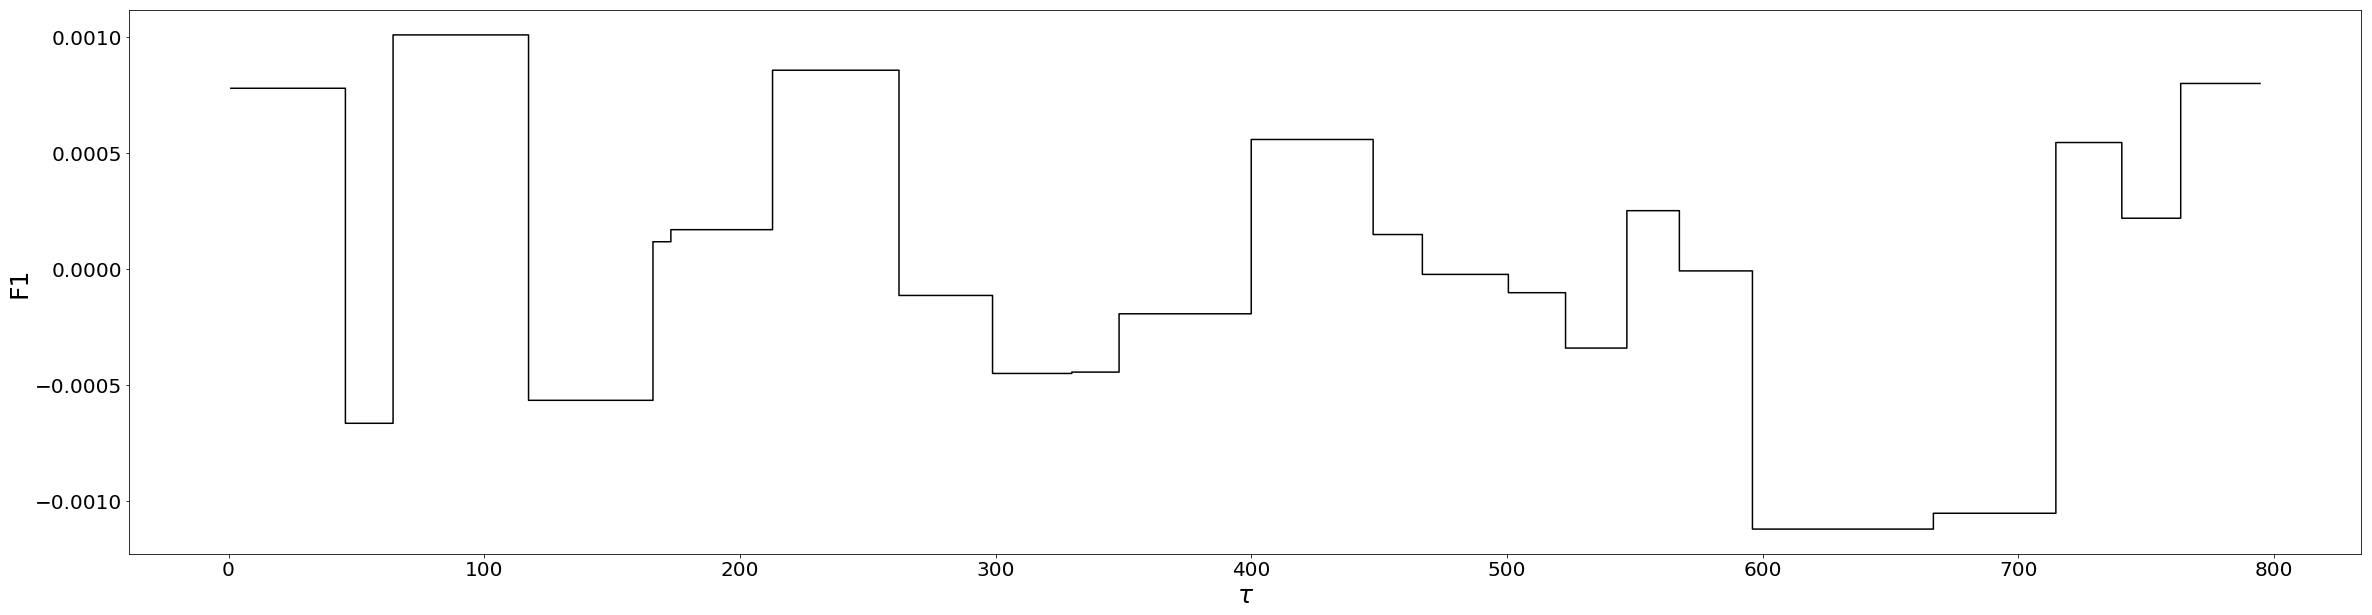

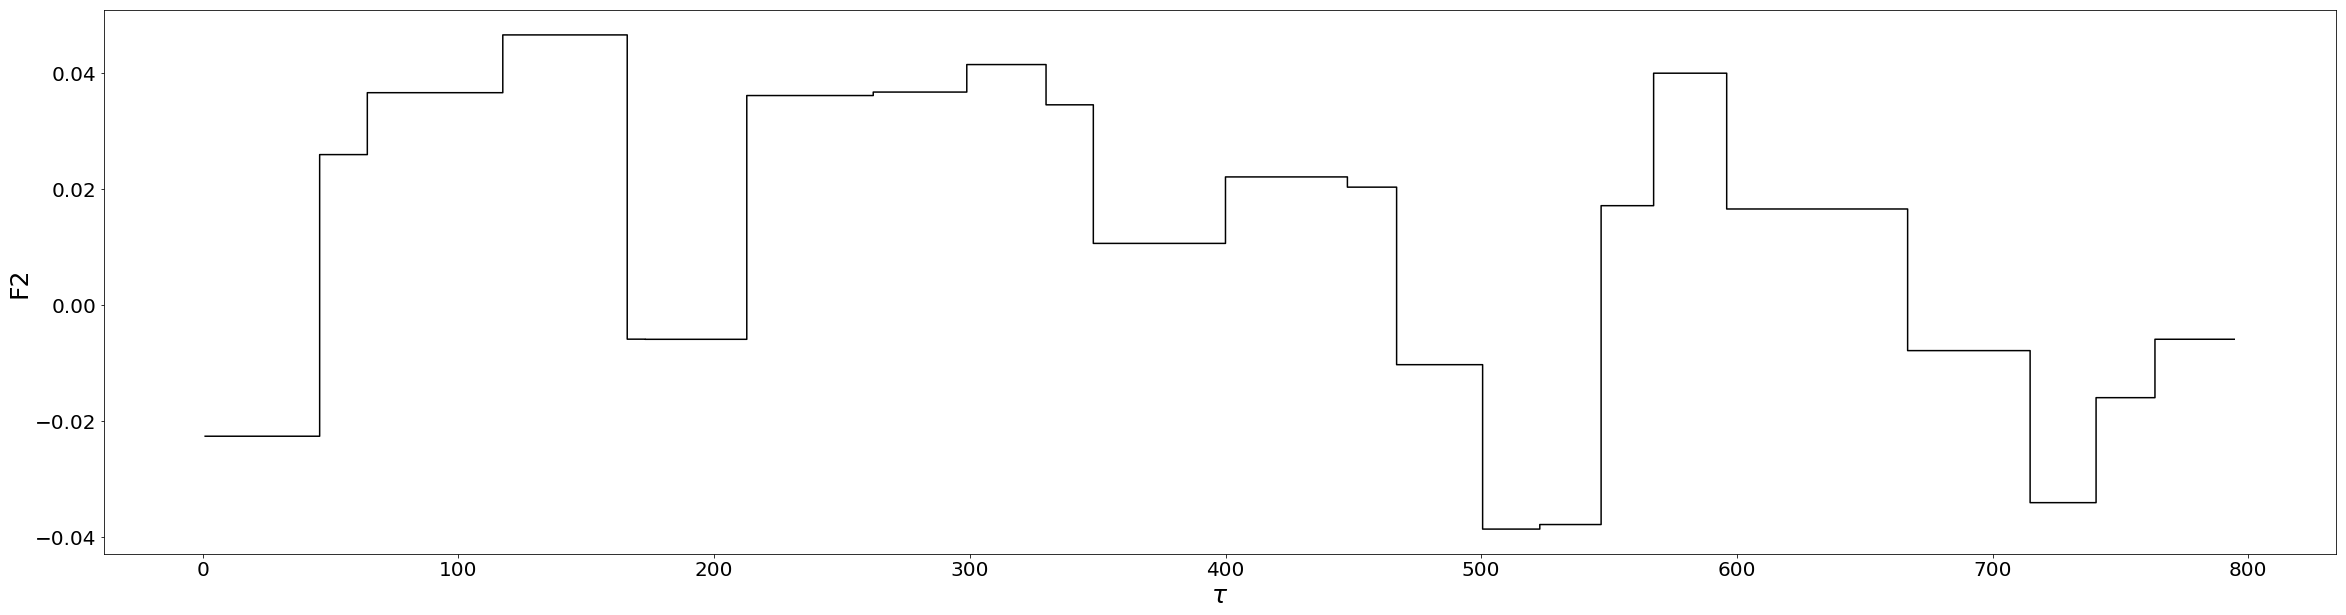



evolution  9


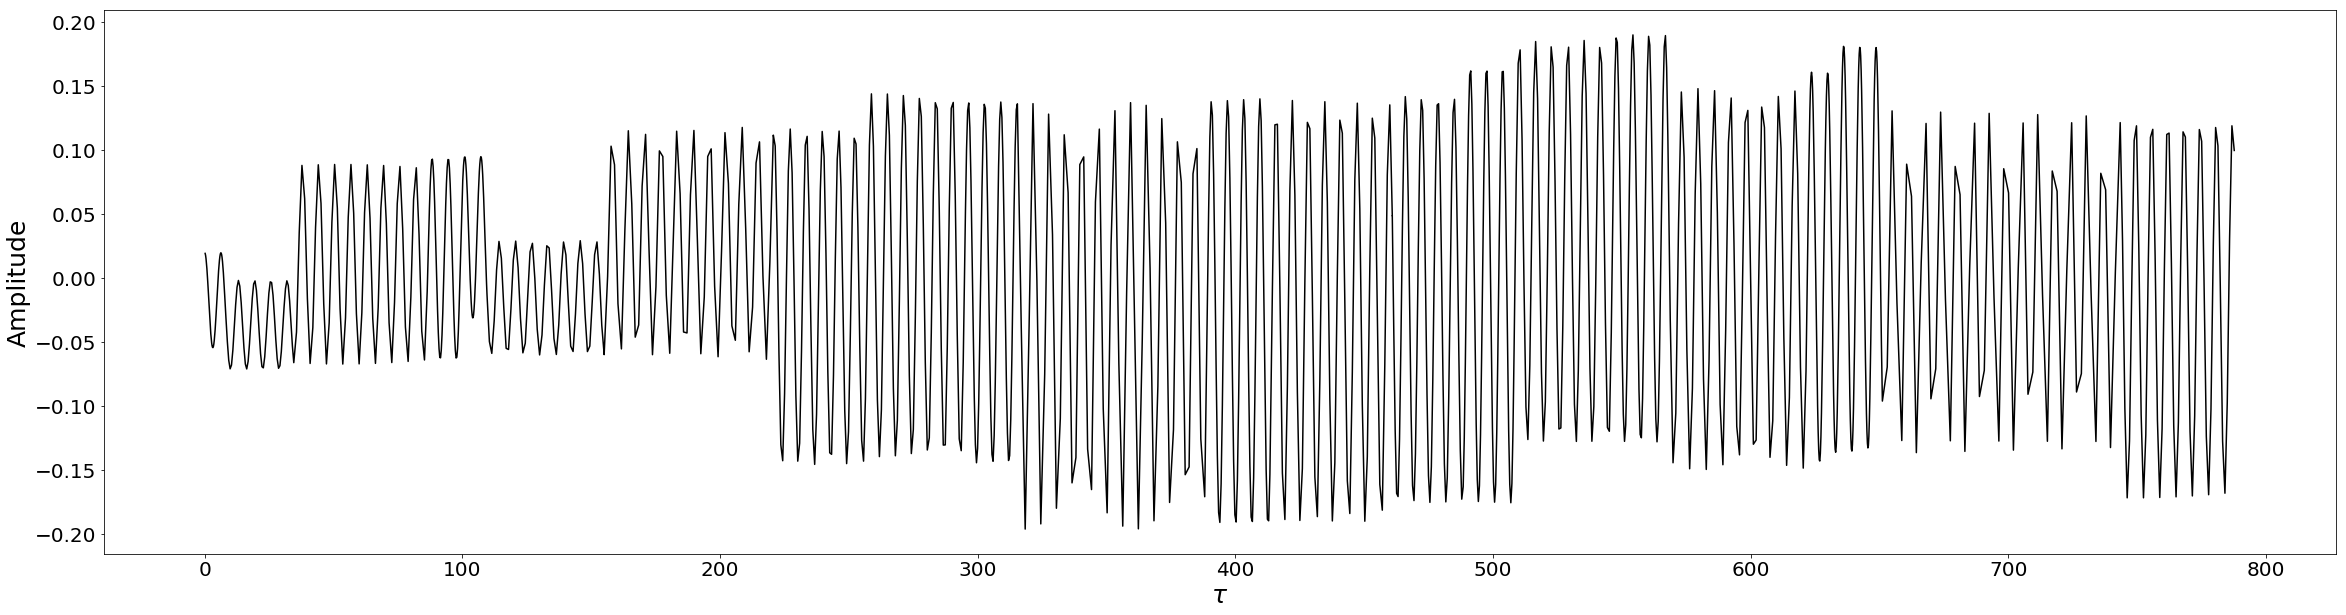

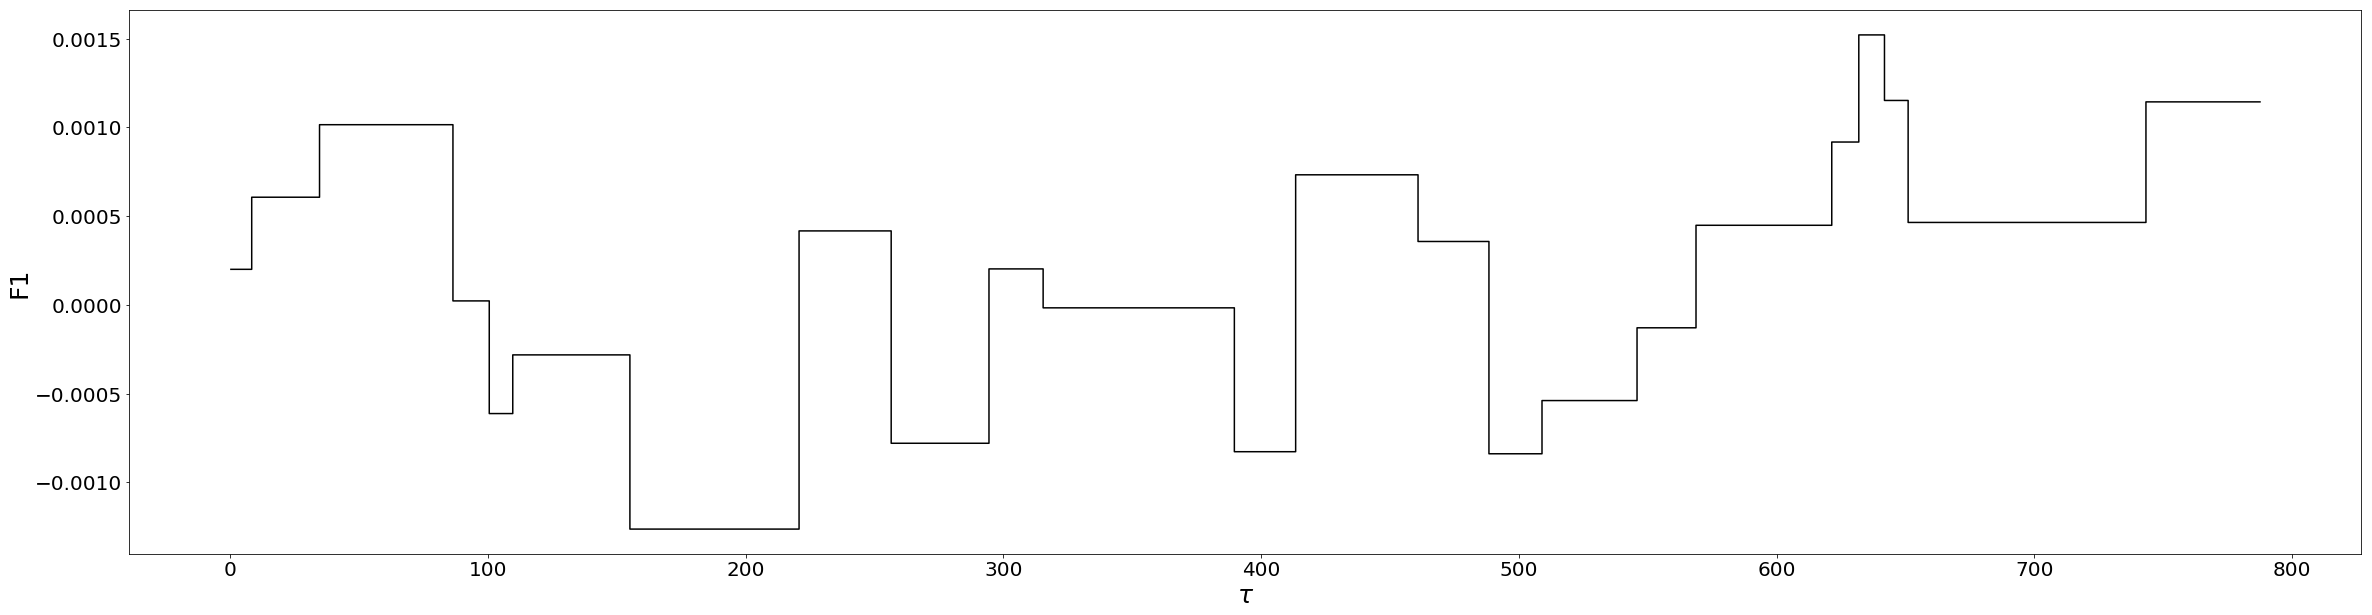

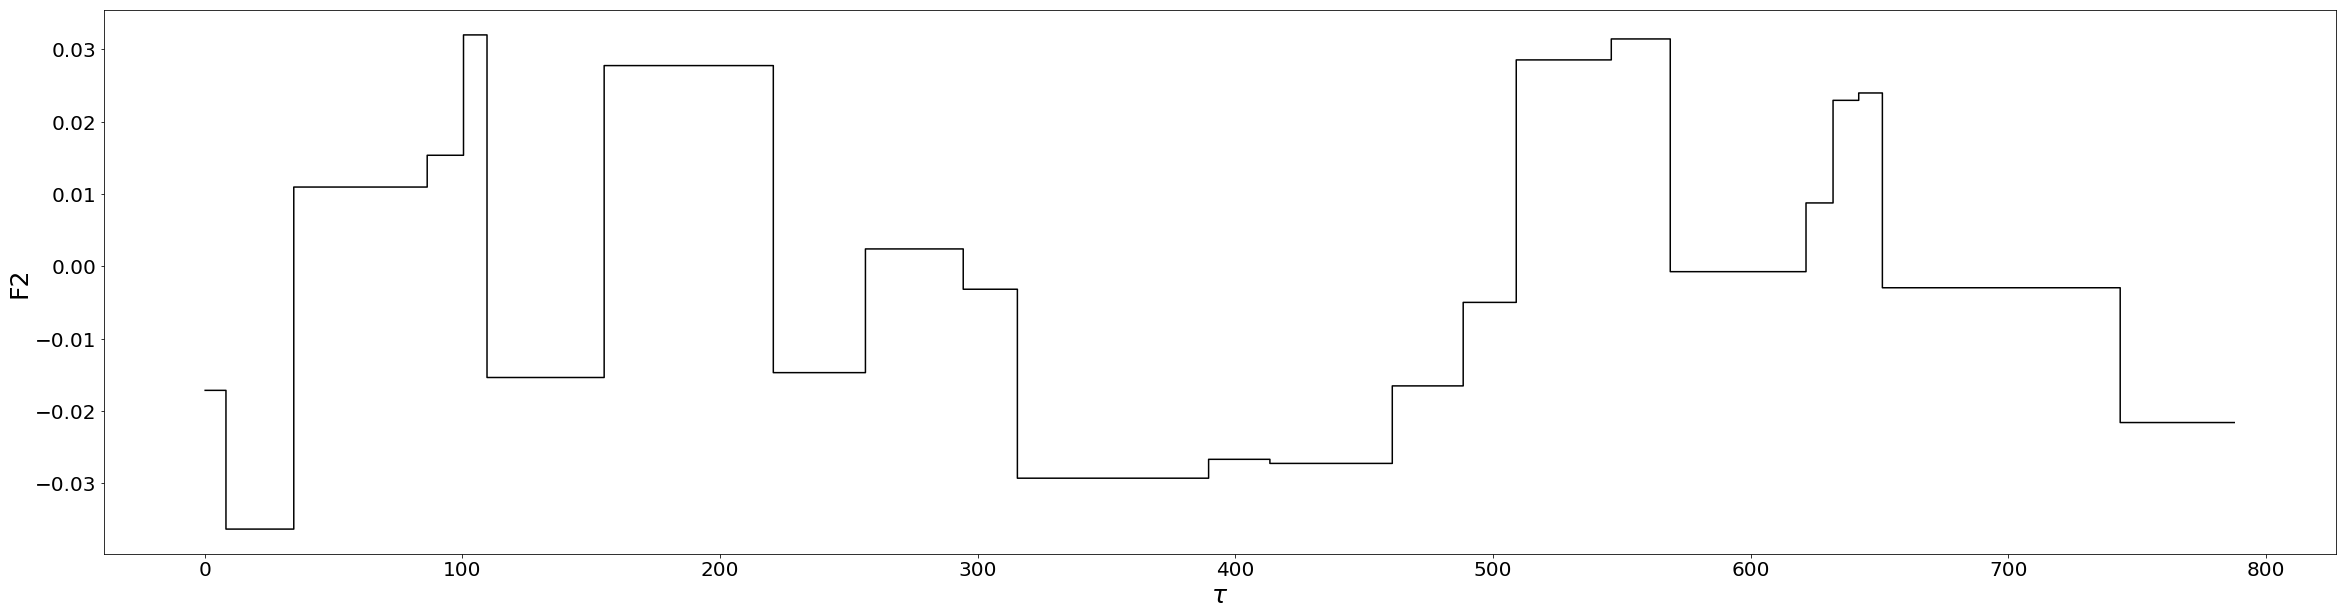



evolution  10


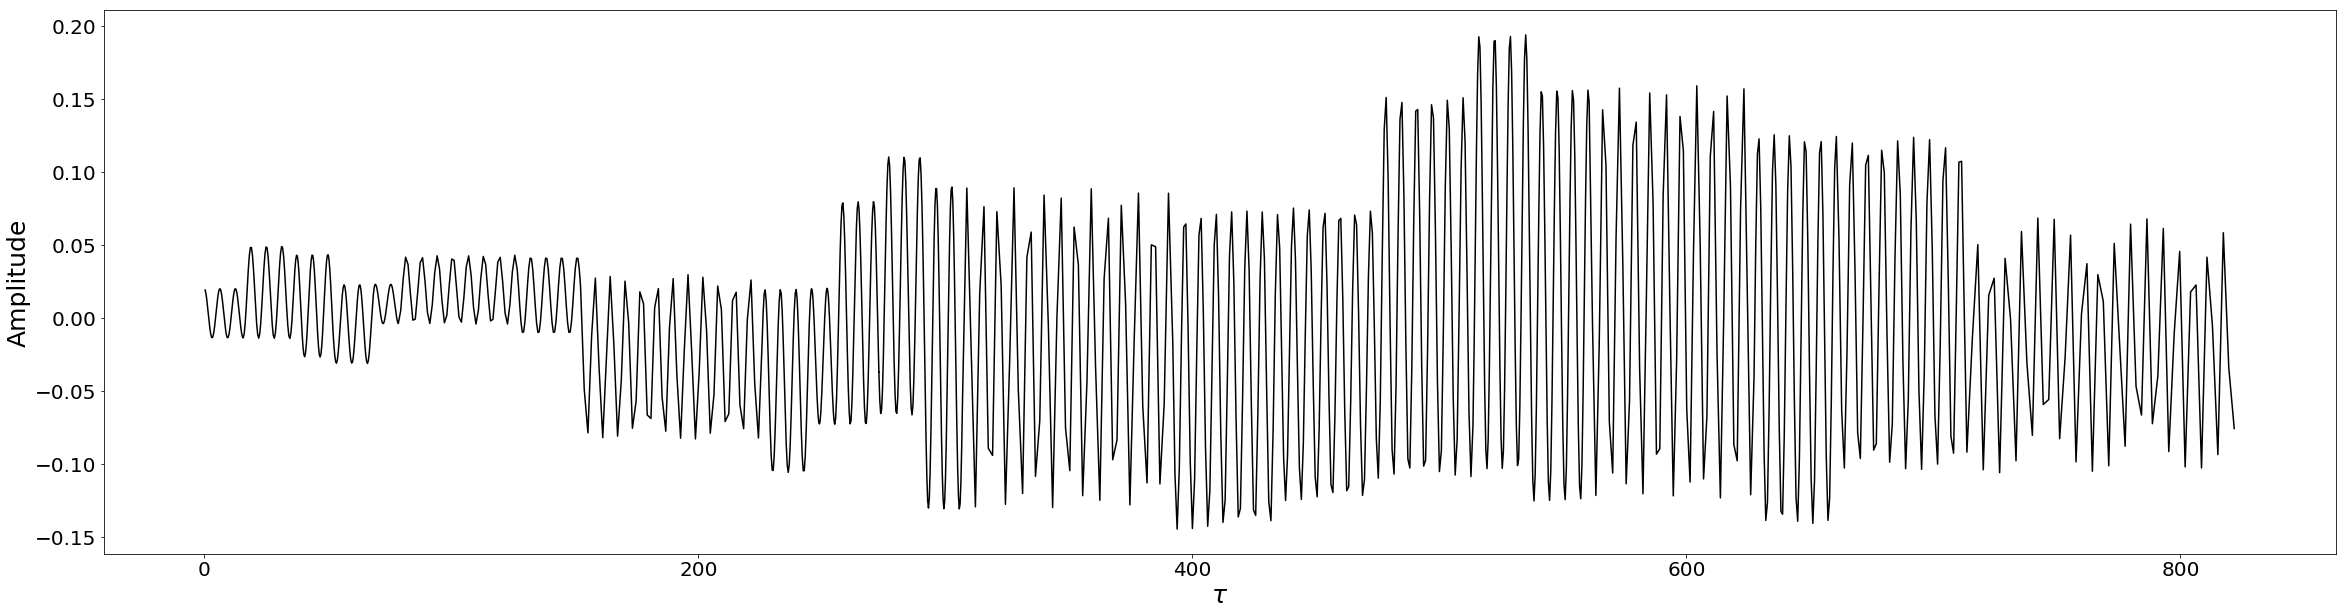

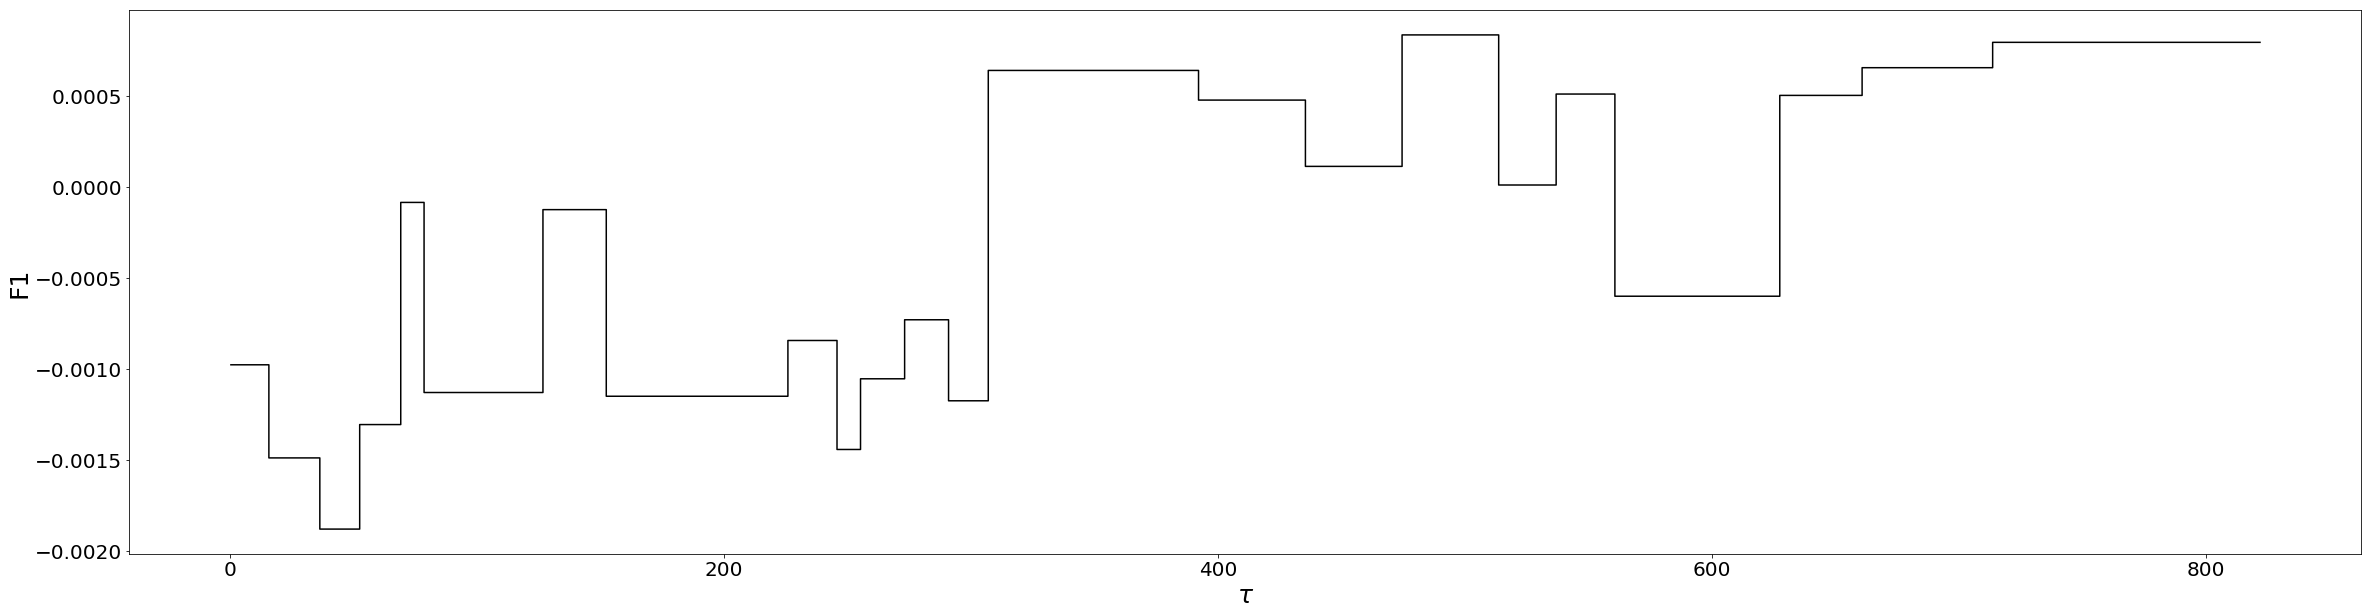

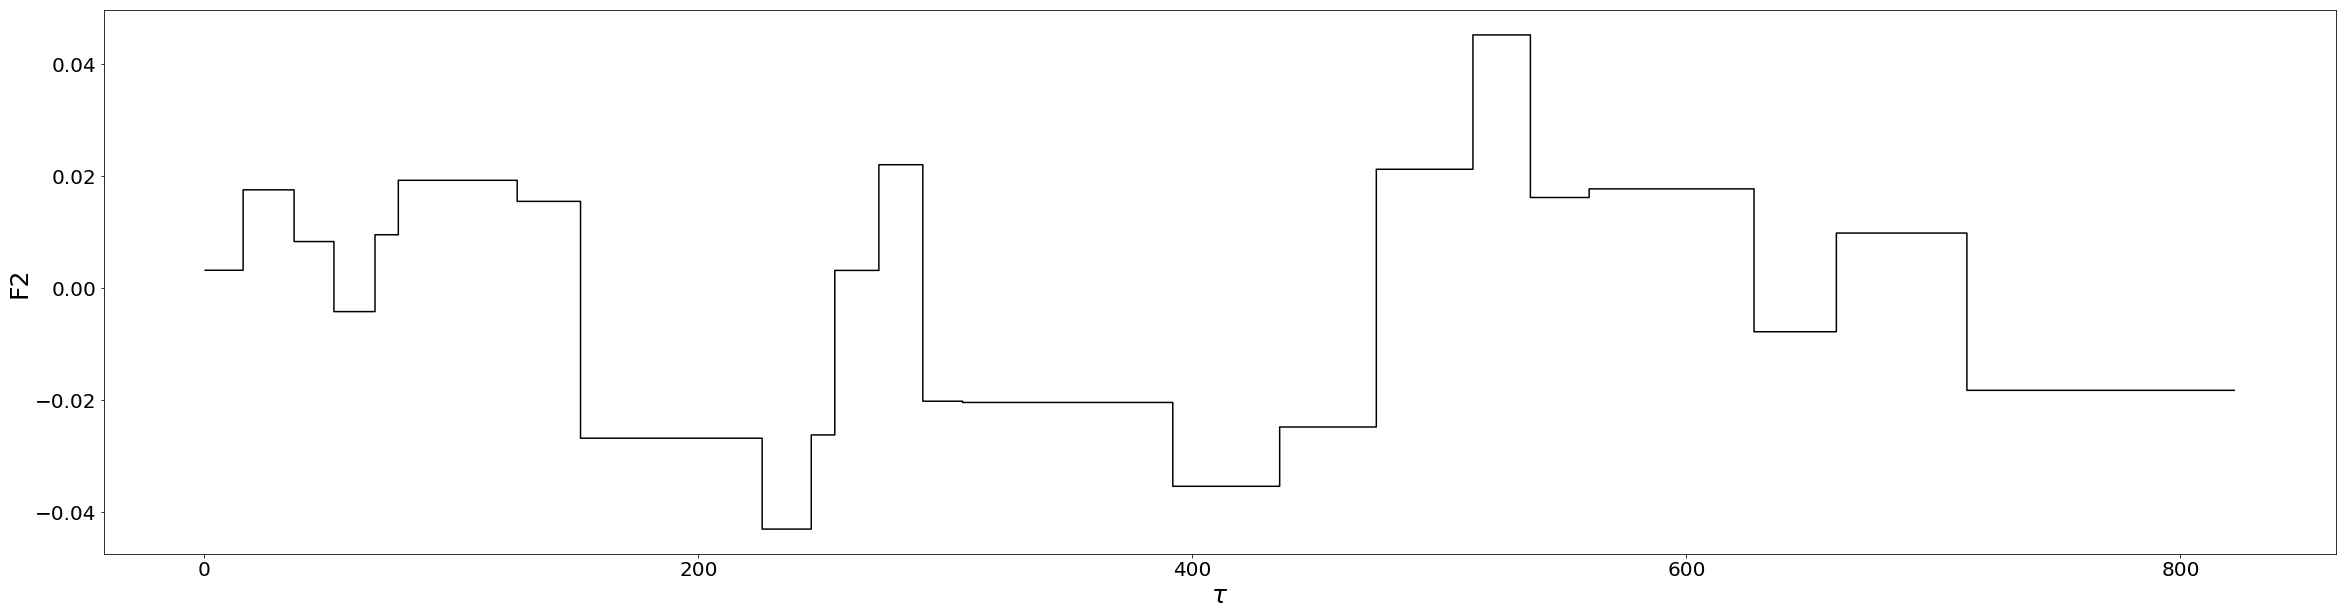

In [14]:
gamma = []
funGamma(A, t, gamma)

print("evolution 1 above")
# collecting nmax values of gamma from L evolutions
for i in range(L-1):
    print("evolution ", i+2)
    deltaT = fundeltaT(n_bins, n_samples)
    Tturb, time = funTturb()
    t = funt()
    F2 = funF2(meanF2, stdF2, Tr)
    F1=funF1(meanF1, stdF1, Tr)
    G1 = funG1(F1)
    A, t, f1, g1, f2 =funAmp(dAdT, AT)
    Funplots(t, A, f1, f2)
    funGamma(A, t, gamma)
    print("\n")

gamma = flatten(gamma)


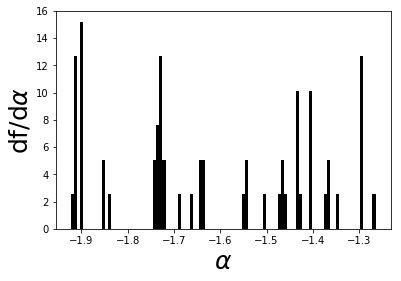

In [15]:
# divide the full range gamma_min <= gamma <= gamma_max into n equal intervals
# delgamma = (gamma_max - gamma_min) / n ~ 4/n

n = 100
gamma_max = max(gamma)
gamma_min = min(gamma)
delgamma = (gamma_max - gamma_min) / n

# we want n(max) << number of samples = L * T(max)/delT = L * M / N
nmax = L * M / N

# plot delf / delgamma vs. gamma
# where delf is the fraction of collected values of gamma within each bin of width delgamma

histogram = plt.hist(gamma, n, density=True, color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('df/d'r'$ \alpha $', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

## Cumulative Distribution Function

In [16]:
# CDF2 = int (df/dgamma) wrt dgamma from gamma to gamma_max
#      = 1 - CDF1
#      = 1 - int (df/dgamma) wrt dgamma from gamma_min to gamma

CDF2 = []
CDF1 = []

# gamma and dfdgamma values pulled from histogram above
gamma_values = histogram[1]
dfdgamma = histogram[0]
gamma_values = np.delete(gamma_values, 0)

index_max = len(gamma_values)-1

for index in range(len(dfdgamma)):
    index_start = index
    sum = 0
    for index_current in range(index_start, index_max):
        sum += dfdgamma[index_current] * gamma_values[index_current]
    CDF2.append(1-sum)
    CDF1.append(sum)
    
normalization_factor = CDF2[0]

CDF2_norm = []
for value in CDF2:
    CDF2_norm.append(value/normalization_factor)
    
CDF1_norm = []
for value in CDF1:
    CDF1_norm.append((value/normalization_factor)+1)
    
CDF2_norm = np.array(CDF2_norm)
CDF1_norm = np.array(CDF1_norm)

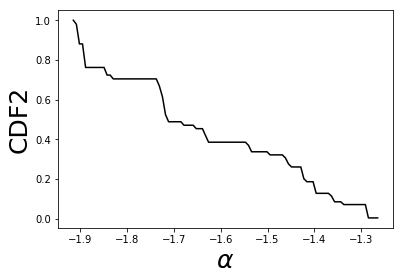

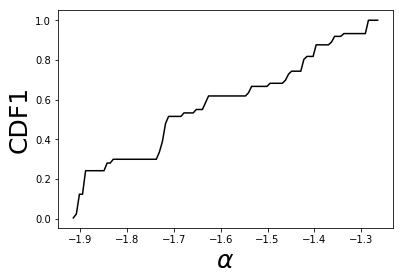

In [17]:
plt.plot(gamma_values, CDF2_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF2', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

plt.plot(gamma_values, CDF1_norm,  color='k')
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.ylabel('CDF1', **axis_font)
plt.xlabel(r'$ \alpha $', **axis_font)
plt.show()

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

CDF1_median = find_nearest(CDF1_norm, 1/2)
index_median =  np.where(CDF1_norm == CDF1_median)
gamma_star = gamma_values[index_median[0]]
print("gamma_star = ", gamma_star)
print("CDF2(median) = ", CDF2_norm[index_median[0]])
print("CDF1(median) = ", CDF1_norm[index_median[0]])

gamma_star =  [-1.71156528 -1.70499383 -1.69842238 -1.69185094 -1.68527949]
CDF2(median) =  [0.48857795 0.48857795 0.48857795 0.48857795 0.48857795]
CDF1(median) =  [0.51552915 0.51552915 0.51552915 0.51552915 0.51552915]
